In [6]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

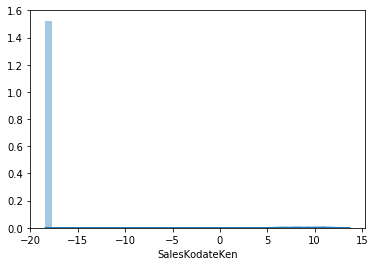

In [3]:
sns.distplot(np.log(df_train_Y['SalesKodateKen'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['SalesKodateKen']:
    df_train_Y['SalesKodateKen_log'] = df_train_Y['SalesKodateKen'].apply(log)
    df_val_Y['SalesKodateKen_log'] = df_val_Y['SalesKodateKen'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['SalesKodateKen_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['SalesKodateKen_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [7]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=100, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['SalesRyutsu'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 1.2855444630081068e-05, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.05432849302355938, 'lambda': 0.010481740696584715, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 4.077771516843325, 'n_estimators': 402.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:15.1661	eval-rmse:15.1856                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.3209	eval-rmse:12.3438                                                                               

[2]	train-rmse:10.0851	eval-rmse:10.1043                                                            

[8]	train-rmse:5.39073	eval-rmse:5.53898                                                                               

[9]	train-rmse:4.88327	eval-rmse:5.05952                                                                               

[10]	train-rmse:4.48061	eval-rmse:4.68686                                                                              

[11]	train-rmse:4.16174	eval-rmse:4.39883                                                                              

[12]	train-rmse:3.91058	eval-rmse:4.17094                                                                              

[13]	train-rmse:3.71538	eval-rmse:4.00286                                                                              

[14]	train-rmse:3.56412	eval-rmse:3.87047                                                                              

[15]	train-rmse:3.44962	eval-rmse:3.77117                                                                              

[16]	train-rmse:3.35948	eval-rms

[20]	train-rmse:3.30391	eval-rmse:4.10511                                                                              

[21]	train-rmse:3.16122	eval-rmse:4.00425                                                                              

[22]	train-rmse:3.04417	eval-rmse:3.91869                                                                              

[23]	train-rmse:2.93844	eval-rmse:3.84826                                                                              

[24]	train-rmse:2.84415	eval-rmse:3.7933                                                                               

[25]	train-rmse:2.76664	eval-rmse:3.75053                                                                              

[26]	train-rmse:2.69847	eval-rmse:3.71898                                                                              

[27]	train-rmse:2.64175	eval-rmse:3.68197                                                                              

[28]	train-rmse:2.59642	eval-rms

[4]	train-rmse:6.1076	eval-rmse:6.25828                                                                                

[5]	train-rmse:5.14599	eval-rmse:5.3333                                                                                

[6]	train-rmse:4.45237	eval-rmse:4.70617                                                                               

[7]	train-rmse:3.97561	eval-rmse:4.27761                                                                               

[8]	train-rmse:3.65477	eval-rmse:3.99201                                                                               

[9]	train-rmse:3.4456	eval-rmse:3.80848                                                                                

[10]	train-rmse:3.30405	eval-rmse:3.70169                                                                              

[11]	train-rmse:3.20322	eval-rmse:3.64789                                                                              

[12]	train-rmse:3.13739	eval-rms

[20]	train-rmse:2.32251	eval-rmse:3.93846                                                                              

[21]	train-rmse:2.28076	eval-rmse:3.96363                                                                              

[22]	train-rmse:2.26005	eval-rmse:3.971                                                                                

[23]	train-rmse:2.22721	eval-rmse:3.97616                                                                              

[24]	train-rmse:2.1955	eval-rmse:3.97926                                                                               

[25]	train-rmse:2.17109	eval-rmse:4.02948                                                                              

[26]	train-rmse:2.16295	eval-rmse:4.03483                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:2.72847	eval-rmse:

[18]	train-rmse:3.11078	eval-rmse:3.53763                                                                              

[19]	train-rmse:3.08777	eval-rmse:3.5403                                                                               

[20]	train-rmse:3.08236	eval-rmse:3.54149                                                                              

[21]	train-rmse:3.06662	eval-rmse:3.53173                                                                              

[22]	train-rmse:3.05362	eval-rmse:3.53032                                                                              

[23]	train-rmse:3.04398	eval-rmse:3.53607                                                                              

[24]	train-rmse:3.03943	eval-rmse:3.54008                                                                              

[25]	train-rmse:3.02949	eval-rmse:3.54698                                                                              

[26]	train-rmse:3.02631	eval-rms

[46]	train-rmse:2.81349	eval-rmse:3.54467                                                                              

[47]	train-rmse:2.80023	eval-rmse:3.54804                                                                              

Stopping. Best iteration:                                                                                              
[27]	train-rmse:2.9668	eval-rmse:3.52645


loss: 113767890.59916396                                                                                               
Training with params:                                                                                                  
{'alpha': 0.04131923780198152, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.00015241184717818714, 'lambda': 0.00014306021422131723, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.7686486030653773, 'n_estimators': 527.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:14.2428	eval-rmse:14.3467                

[12]	train-rmse:3.40766	eval-rmse:3.49774                                                                              

[13]	train-rmse:3.39817	eval-rmse:3.49819                                                                              

[14]	train-rmse:3.39101	eval-rmse:3.50139                                                                              

[15]	train-rmse:3.38707	eval-rmse:3.50402                                                                              

[16]	train-rmse:3.38314	eval-rmse:3.49966                                                                              

[17]	train-rmse:3.3782	eval-rmse:3.49806                                                                               

[18]	train-rmse:3.36995	eval-rmse:3.49983                                                                              

[19]	train-rmse:3.36531	eval-rmse:3.50307                                                                              

[20]	train-rmse:3.36072	eval-rms

[39]	train-rmse:3.10994	eval-rmse:3.50778                                                                              

[40]	train-rmse:3.10128	eval-rmse:3.50475                                                                              

[41]	train-rmse:3.0948	eval-rmse:3.50116                                                                               

[42]	train-rmse:3.09061	eval-rmse:3.49805                                                                              

[43]	train-rmse:3.08426	eval-rmse:3.49701                                                                              

[44]	train-rmse:3.07893	eval-rmse:3.49516                                                                              

[45]	train-rmse:3.07068	eval-rmse:3.49658                                                                              

[46]	train-rmse:3.06893	eval-rmse:3.49677                                                                              

[47]	train-rmse:3.06581	eval-rms

[34]	train-rmse:4.45287	eval-rmse:4.64567                                                                              

[35]	train-rmse:4.34497	eval-rmse:4.54473                                                                              

[36]	train-rmse:4.24468	eval-rmse:4.45134                                                                              

[37]	train-rmse:4.15231	eval-rmse:4.36211                                                                              

[38]	train-rmse:4.06466	eval-rmse:4.282                                                                                

[39]	train-rmse:3.98447	eval-rmse:4.2108                                                                               

[40]	train-rmse:3.9114	eval-rmse:4.14256                                                                               

[41]	train-rmse:3.84275	eval-rmse:4.08092                                                                              

[42]	train-rmse:3.77919	eval-rms

Training with params:                                                                                                  
{'alpha': 0.06465935728267116, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.024512602093121144, 'lambda': 2.939206986736404e-06, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 0.3102725406569172, 'n_estimators': 194.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:18.315	eval-rmse:18.3275                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:17.8775	eval-rmse:17.8869                                                                               

[2]	train-rmse:17.4474	eval-rmse:17.4581                                                          

[62]	train-rmse:5.09177	eval-rmse:5.11638                                                                              

[63]	train-rmse:5.02196	eval-rmse:5.0475                                                                               

[64]	train-rmse:4.95615	eval-rmse:4.98121                                                                              

[65]	train-rmse:4.89094	eval-rmse:4.91692                                                                              

[66]	train-rmse:4.82924	eval-rmse:4.85509                                                                              

[67]	train-rmse:4.76953	eval-rmse:4.79595                                                                              

[68]	train-rmse:4.71153	eval-rmse:4.74025                                                                              

[69]	train-rmse:4.65696	eval-rmse:4.68568                                                                              

[70]	train-rmse:4.60361	eval-rms

[23]	train-rmse:2.75337	eval-rmse:3.58231                                                                              

[24]	train-rmse:2.73159	eval-rmse:3.57596                                                                              

[25]	train-rmse:2.71716	eval-rmse:3.57671                                                                              

[26]	train-rmse:2.70258	eval-rmse:3.58185                                                                              

[27]	train-rmse:2.69089	eval-rmse:3.58568                                                                              

[28]	train-rmse:2.67952	eval-rmse:3.59165                                                                              

[29]	train-rmse:2.66705	eval-rmse:3.59302                                                                              

[30]	train-rmse:2.64634	eval-rmse:3.59749                                                                              

[31]	train-rmse:2.628	eval-rmse:

[37]	train-rmse:2.80756	eval-rmse:3.58094                                                                              

[38]	train-rmse:2.80474	eval-rmse:3.57969                                                                              

[39]	train-rmse:2.80007	eval-rmse:3.5751                                                                               

[40]	train-rmse:2.79063	eval-rmse:3.57388                                                                              

[41]	train-rmse:2.7823	eval-rmse:3.57717                                                                               

[42]	train-rmse:2.77444	eval-rmse:3.57778                                                                              

[43]	train-rmse:2.75685	eval-rmse:3.57907                                                                              

[44]	train-rmse:2.75156	eval-rmse:3.58292                                                                              

[45]	train-rmse:2.73919	eval-rms

[44]	train-rmse:3.38885	eval-rmse:3.48379                                                                              

[45]	train-rmse:3.38545	eval-rmse:3.48722                                                                              

[46]	train-rmse:3.38292	eval-rmse:3.48766                                                                              

[47]	train-rmse:3.38039	eval-rmse:3.48564                                                                              

[48]	train-rmse:3.37842	eval-rmse:3.4867                                                                               

[49]	train-rmse:3.37676	eval-rmse:3.48524                                                                              

[50]	train-rmse:3.37566	eval-rmse:3.48518                                                                              

[51]	train-rmse:3.37288	eval-rmse:3.48587                                                                              

[52]	train-rmse:3.37059	eval-rms

Training with params:                                                                                                  
{'alpha': 0.000686530707681295, 'colsample_bytree': 0.65, 'gamma': 2.603637102805661e-06, 'lambda': 0.0018215891431608497, 'learning_rate': 0.125, 'max_depth': 3, 'min_child_weight': 0.354704808863008, 'n_estimators': 981.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:16.5152	eval-rmse:16.5231                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.5526	eval-rmse:14.5629                                                                               

[2]	train-rmse:12.8501	eval-rmse:12.8621                                                                               

[3]	t

Training with params:                                                                                                  
{'alpha': 4.7289932536878903e-07, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0001648551293906739, 'lambda': 0.00016765151185336235, 'learning_rate': 0.325, 'max_depth': 5, 'min_child_weight': 0.2984525380439323, 'n_estimators': 736.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:12.9311	eval-rmse:12.9564                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.09275	eval-rmse:9.1245                                                                                

[2]	train-rmse:6.63556	eval-rmse:6.69337                                                     

[15]	train-rmse:2.61607	eval-rmse:3.64186                                                                              

[16]	train-rmse:2.60607	eval-rmse:3.64393                                                                              

[17]	train-rmse:2.57896	eval-rmse:3.64474                                                                              

[18]	train-rmse:2.55862	eval-rmse:3.64384                                                                              

[19]	train-rmse:2.5421	eval-rmse:3.64469                                                                               

[20]	train-rmse:2.5115	eval-rmse:3.64459                                                                               

[21]	train-rmse:2.49794	eval-rmse:3.65433                                                                              

[22]	train-rmse:2.47739	eval-rmse:3.65534                                                                              

[23]	train-rmse:2.45245	eval-rms

[44]	train-rmse:3.66633	eval-rmse:3.92744                                                                              

[45]	train-rmse:3.61594	eval-rmse:3.8889                                                                               

[46]	train-rmse:3.57182	eval-rmse:3.84977                                                                              

[47]	train-rmse:3.52856	eval-rmse:3.8147                                                                               

[48]	train-rmse:3.48998	eval-rmse:3.78293                                                                              

[49]	train-rmse:3.45448	eval-rmse:3.75277                                                                              

[50]	train-rmse:3.42212	eval-rmse:3.72359                                                                              

[51]	train-rmse:3.39109	eval-rmse:3.6992                                                                               

[52]	train-rmse:3.36331	eval-rms

[5]	train-rmse:16.2177	eval-rmse:16.2386                                                                               

[6]	train-rmse:15.8301	eval-rmse:15.8528                                                                               

[7]	train-rmse:15.4521	eval-rmse:15.4765                                                                               

[8]	train-rmse:15.0858	eval-rmse:15.1112                                                                               

[9]	train-rmse:14.7254	eval-rmse:14.7539                                                                               

[10]	train-rmse:14.377	eval-rmse:14.4071                                                                               

[11]	train-rmse:14.0394	eval-rmse:14.0681                                                                              

[12]	train-rmse:13.708	eval-rmse:13.7384                                                                               

[13]	train-rmse:13.386	eval-rmse

[72]	train-rmse:4.33105	eval-rmse:4.54712                                                                              

[73]	train-rmse:4.27982	eval-rmse:4.50018                                                                              

[74]	train-rmse:4.2312	eval-rmse:4.45515                                                                               

[75]	train-rmse:4.18362	eval-rmse:4.41228                                                                              

[76]	train-rmse:4.13917	eval-rmse:4.37085                                                                              

[77]	train-rmse:4.0951	eval-rmse:4.33077                                                                               

[78]	train-rmse:4.05333	eval-rmse:4.29233                                                                              

[79]	train-rmse:4.01281	eval-rmse:4.25537                                                                              

[80]	train-rmse:3.97428	eval-rms

[33]	train-rmse:3.41361	eval-rmse:3.71943                                                                              

[34]	train-rmse:3.37069	eval-rmse:3.68801                                                                              

[35]	train-rmse:3.33329	eval-rmse:3.65682                                                                              

[36]	train-rmse:3.29699	eval-rmse:3.62869                                                                              

[37]	train-rmse:3.2688	eval-rmse:3.60749                                                                               

[38]	train-rmse:3.2407	eval-rmse:3.59005                                                                               

[39]	train-rmse:3.21976	eval-rmse:3.57157                                                                              

[40]	train-rmse:3.20112	eval-rmse:3.55957                                                                              

[41]	train-rmse:3.18287	eval-rms

loss: 113767890.35649793                                                                                               
Training with params:                                                                                                  
{'alpha': 0.007220074318384763, 'colsample_bytree': 0.9, 'gamma': 0.34338845920292177, 'lambda': 0.07918107634423602, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'min_child_weight': 0.10613641691149746, 'n_estimators': 396.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:16.0516	eval-rmse:16.0796                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.7621	eval-rmse:13.7985                                                                            

[6]	train-rmse:13.3406	eval-rmse:13.3662                                                                               

[7]	train-rmse:12.7192	eval-rmse:12.747                                                                                

[8]	train-rmse:12.1325	eval-rmse:12.1605                                                                               

[9]	train-rmse:11.5724	eval-rmse:11.6067                                                                               

[10]	train-rmse:11.0485	eval-rmse:11.0819                                                                              

[11]	train-rmse:10.5486	eval-rmse:10.5855                                                                              

[12]	train-rmse:10.0783	eval-rmse:10.1179                                                                              

[13]	train-rmse:9.63353	eval-rmse:9.67548                                                                              

[14]	train-rmse:9.21338	eval-rms

[73]	train-rmse:3.26284	eval-rmse:3.50232                                                                              

[74]	train-rmse:3.2568	eval-rmse:3.49966                                                                               

[75]	train-rmse:3.25449	eval-rmse:3.49722                                                                              

[76]	train-rmse:3.24987	eval-rmse:3.49517                                                                              

[77]	train-rmse:3.24691	eval-rmse:3.49322                                                                              

[78]	train-rmse:3.24404	eval-rmse:3.49159                                                                              

[79]	train-rmse:3.24075	eval-rmse:3.49042                                                                              

[80]	train-rmse:3.23727	eval-rmse:3.48981                                                                              

[81]	train-rmse:3.2342	eval-rmse

[34]	train-rmse:3.08863	eval-rmse:3.53761                                                                              

[35]	train-rmse:3.07755	eval-rmse:3.53553                                                                              

[36]	train-rmse:3.0733	eval-rmse:3.53598                                                                               

[37]	train-rmse:3.06471	eval-rmse:3.5377                                                                               

[38]	train-rmse:3.05902	eval-rmse:3.54148                                                                              

[39]	train-rmse:3.05635	eval-rmse:3.53962                                                                              

[40]	train-rmse:3.0498	eval-rmse:3.53904                                                                               

[41]	train-rmse:3.04536	eval-rmse:3.53816                                                                              

[42]	train-rmse:3.04165	eval-rms

[37]	train-rmse:3.27588	eval-rmse:3.61279                                                                              

[38]	train-rmse:3.25105	eval-rmse:3.59477                                                                              

[39]	train-rmse:3.22619	eval-rmse:3.58041                                                                              

[40]	train-rmse:3.20525	eval-rmse:3.56611                                                                              

[41]	train-rmse:3.18755	eval-rmse:3.55305                                                                              

[42]	train-rmse:3.17433	eval-rmse:3.54306                                                                              

[43]	train-rmse:3.16064	eval-rmse:3.53216                                                                              

[44]	train-rmse:3.14825	eval-rmse:3.52297                                                                              

[45]	train-rmse:3.13524	eval-rms

[7]	train-rmse:7.05078	eval-rmse:7.27688                                                                               

[8]	train-rmse:6.3285	eval-rmse:6.60597                                                                                

[9]	train-rmse:5.71042	eval-rmse:6.03226                                                                               

[10]	train-rmse:5.18454	eval-rmse:5.55726                                                                              

[11]	train-rmse:4.74084	eval-rmse:5.16058                                                                              

[12]	train-rmse:4.36815	eval-rmse:4.8406                                                                               

[13]	train-rmse:4.05774	eval-rmse:4.57553                                                                              

[14]	train-rmse:3.79906	eval-rmse:4.36153                                                                              

[15]	train-rmse:3.58043	eval-rms

[3]	train-rmse:8.18159	eval-rmse:8.38972                                                                               

[4]	train-rmse:6.77431	eval-rmse:7.04774                                                                               

[5]	train-rmse:5.6926	eval-rmse:6.03313                                                                                

[6]	train-rmse:4.86349	eval-rmse:5.27219                                                                               

[7]	train-rmse:4.24744	eval-rmse:4.72009                                                                               

[8]	train-rmse:3.78957	eval-rmse:4.33615                                                                               

[9]	train-rmse:3.45059	eval-rmse:4.06428                                                                               

[10]	train-rmse:3.20227	eval-rmse:3.87312                                                                              

[11]	train-rmse:3.03874	eval-rms

[23]	train-rmse:2.66866	eval-rmse:3.62335                                                                              

[24]	train-rmse:2.64833	eval-rmse:3.6197                                                                               

[25]	train-rmse:2.63357	eval-rmse:3.61644                                                                              

[26]	train-rmse:2.61618	eval-rmse:3.61007                                                                              

[27]	train-rmse:2.60778	eval-rmse:3.61231                                                                              

[28]	train-rmse:2.59562	eval-rmse:3.61139                                                                              

[29]	train-rmse:2.58612	eval-rmse:3.61055                                                                              

[30]	train-rmse:2.57633	eval-rmse:3.61113                                                                              

[31]	train-rmse:2.56998	eval-rms

[35]	train-rmse:2.65067	eval-rmse:3.51634                                                                              

[36]	train-rmse:2.64011	eval-rmse:3.51153                                                                              

[37]	train-rmse:2.62663	eval-rmse:3.5105                                                                               

[38]	train-rmse:2.61717	eval-rmse:3.50843                                                                              

[39]	train-rmse:2.60558	eval-rmse:3.50794                                                                              

[40]	train-rmse:2.59651	eval-rmse:3.50796                                                                              

[41]	train-rmse:2.58834	eval-rmse:3.50546                                                                              

[42]	train-rmse:2.58252	eval-rmse:3.50326                                                                              

[43]	train-rmse:2.5746	eval-rmse

[3]	train-rmse:12.5518	eval-rmse:12.632                                                                                

[4]	train-rmse:11.3794	eval-rmse:11.4747                                                                               

[5]	train-rmse:10.3288	eval-rmse:10.4411                                                                               

[6]	train-rmse:9.3922	eval-rmse:9.52565                                                                                

[7]	train-rmse:8.55512	eval-rmse:8.71378                                                                               

[8]	train-rmse:7.81112	eval-rmse:7.99107                                                                               

[9]	train-rmse:7.14938	eval-rmse:7.35376                                                                               

[10]	train-rmse:6.56241	eval-rmse:6.79424                                                                              

[11]	train-rmse:6.04297	eval-rms

[70]	train-rmse:2.58826	eval-rmse:3.49087                                                                              

[71]	train-rmse:2.58403	eval-rmse:3.4912                                                                               

[72]	train-rmse:2.58143	eval-rmse:3.49185                                                                              

[73]	train-rmse:2.57277	eval-rmse:3.49271                                                                              

[74]	train-rmse:2.56982	eval-rmse:3.49525                                                                              

[75]	train-rmse:2.56238	eval-rmse:3.49689                                                                              

[76]	train-rmse:2.5589	eval-rmse:3.49746                                                                               

[77]	train-rmse:2.55364	eval-rmse:3.49681                                                                              

[78]	train-rmse:2.54469	eval-rms

loss: 113790282.47405376                                                                                               
Training with params:                                                                                                  
{'alpha': 1.0751276136725218e-07, 'colsample_bytree': 0.9, 'gamma': 1.014563115740662e-08, 'lambda': 0.49912479586219716, 'learning_rate': 0.125, 'max_depth': 8, 'min_child_weight': 1.0442228153852944, 'n_estimators': 713.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:16.4953	eval-rmse:16.5295                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.5166	eval-rmse:14.5727                                                                               

[2]	tr

Training with params:                                                                                                  
{'alpha': 3.602988856974063e-08, 'colsample_bytree': 0.9, 'gamma': 1.093048989570738e-08, 'lambda': 0.018466578689029862, 'learning_rate': 0.275, 'max_depth': 8, 'min_child_weight': 0.9421523651440817, 'n_estimators': 719.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:13.7882	eval-rmse:13.8548                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.2243	eval-rmse:10.3427                                                                               

[2]	train-rmse:7.70576	eval-rmse:7.90095                                                                               

[3]	t

[12]	train-rmse:2.71476	eval-rmse:3.64393                                                                              

[13]	train-rmse:2.70422	eval-rmse:3.64875                                                                              

[14]	train-rmse:2.69196	eval-rmse:3.65611                                                                              

[15]	train-rmse:2.67244	eval-rmse:3.65576                                                                              

[16]	train-rmse:2.63569	eval-rmse:3.66866                                                                              

[17]	train-rmse:2.61846	eval-rmse:3.68156                                                                              

[18]	train-rmse:2.5786	eval-rmse:3.68057                                                                               

[19]	train-rmse:2.54626	eval-rmse:3.68562                                                                              

[20]	train-rmse:2.52709	eval-rms

[42]	train-rmse:3.30403	eval-rmse:3.49334                                                                              

[43]	train-rmse:3.29841	eval-rmse:3.49405                                                                              

[44]	train-rmse:3.29451	eval-rmse:3.4921                                                                               

[45]	train-rmse:3.29165	eval-rmse:3.49402                                                                              

[46]	train-rmse:3.28919	eval-rmse:3.49638                                                                              

[47]	train-rmse:3.28653	eval-rmse:3.49622                                                                              

[48]	train-rmse:3.28236	eval-rmse:3.4992                                                                               

[49]	train-rmse:3.27954	eval-rmse:3.49904                                                                              

[50]	train-rmse:3.27594	eval-rms

[37]	train-rmse:2.45064	eval-rmse:3.62653                                                                              

[38]	train-rmse:2.44234	eval-rmse:3.62326                                                                              

[39]	train-rmse:2.43055	eval-rmse:3.62358                                                                              

[40]	train-rmse:2.4174	eval-rmse:3.62304                                                                               

[41]	train-rmse:2.41218	eval-rmse:3.62383                                                                              

[42]	train-rmse:2.40349	eval-rmse:3.62896                                                                              

[43]	train-rmse:2.38761	eval-rmse:3.63166                                                                              

[44]	train-rmse:2.3745	eval-rmse:3.6315                                                                                

Stopping. Best iteration:       

[16]	train-rmse:2.40792	eval-rmse:3.65226                                                                              

[17]	train-rmse:2.39583	eval-rmse:3.6477                                                                               

[18]	train-rmse:2.38663	eval-rmse:3.64209                                                                              

[19]	train-rmse:2.37152	eval-rmse:3.64287                                                                              

[20]	train-rmse:2.36293	eval-rmse:3.64125                                                                              

[21]	train-rmse:2.3461	eval-rmse:3.6514                                                                                

[22]	train-rmse:2.33412	eval-rmse:3.65018                                                                              

[23]	train-rmse:2.30203	eval-rmse:3.65882                                                                              

[24]	train-rmse:2.28813	eval-rms

[35]	train-rmse:2.85437	eval-rmse:3.56012                                                                              

[36]	train-rmse:2.84746	eval-rmse:3.56118                                                                              

[37]	train-rmse:2.83775	eval-rmse:3.56322                                                                              

[38]	train-rmse:2.83277	eval-rmse:3.56031                                                                              

[39]	train-rmse:2.8256	eval-rmse:3.55749                                                                               

[40]	train-rmse:2.81644	eval-rmse:3.55717                                                                              

[41]	train-rmse:2.81092	eval-rmse:3.55689                                                                              

[42]	train-rmse:2.80409	eval-rmse:3.55826                                                                              

[43]	train-rmse:2.79358	eval-rms

[33]	train-rmse:3.05436	eval-rmse:3.75639                                                                              

[34]	train-rmse:3.00662	eval-rmse:3.72277                                                                              

[35]	train-rmse:2.96084	eval-rmse:3.6865                                                                               

[36]	train-rmse:2.91987	eval-rmse:3.66052                                                                              

[37]	train-rmse:2.88331	eval-rmse:3.63644                                                                              

[38]	train-rmse:2.85398	eval-rmse:3.61971                                                                              

[39]	train-rmse:2.82462	eval-rmse:3.60216                                                                              

[40]	train-rmse:2.79995	eval-rmse:3.58849                                                                              

[41]	train-rmse:2.7799	eval-rmse

loss: 113767891.13906342                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0001439605306581993, 'colsample_bytree': 0.8, 'gamma': 0.00027700108778294695, 'lambda': 3.0347111810285887, 'learning_rate': 0.275, 'max_depth': 4, 'min_child_weight': 0.15157913075962337, 'n_estimators': 445.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:13.8254	eval-rmse:13.8377                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.3125	eval-rmse:10.3255                                                                        

[3]	train-rmse:4.45906	eval-rmse:4.87407                                                                               

[4]	train-rmse:3.63722	eval-rmse:4.16622                                                                               

[5]	train-rmse:3.19191	eval-rmse:3.82716                                                                               

[6]	train-rmse:2.95987	eval-rmse:3.68099                                                                               

[7]	train-rmse:2.8371	eval-rmse:3.6184                                                                                 

[8]	train-rmse:2.78032	eval-rmse:3.58677                                                                               

[9]	train-rmse:2.75126	eval-rmse:3.57749                                                                               

[10]	train-rmse:2.72495	eval-rmse:3.57849                                                                              

[11]	train-rmse:2.70867	eval-rms

[26]	train-rmse:2.87426	eval-rmse:3.52825                                                                              

[27]	train-rmse:2.86742	eval-rmse:3.52571                                                                              

[28]	train-rmse:2.85796	eval-rmse:3.524                                                                                

[29]	train-rmse:2.84772	eval-rmse:3.5257                                                                               

[30]	train-rmse:2.83777	eval-rmse:3.52233                                                                              

[31]	train-rmse:2.83351	eval-rmse:3.52151                                                                              

[32]	train-rmse:2.82874	eval-rmse:3.52114                                                                              

[33]	train-rmse:2.81608	eval-rmse:3.5212                                                                               

[34]	train-rmse:2.81282	eval-rms

[29]	train-rmse:3.40915	eval-rmse:3.50791                                                                              

[30]	train-rmse:3.4075	eval-rmse:3.50651                                                                               

[31]	train-rmse:3.406	eval-rmse:3.50697                                                                                

[32]	train-rmse:3.40444	eval-rmse:3.50708                                                                              

[33]	train-rmse:3.40315	eval-rmse:3.5054                                                                               

[34]	train-rmse:3.39928	eval-rmse:3.5005                                                                               

[35]	train-rmse:3.39607	eval-rmse:3.5003                                                                               

[36]	train-rmse:3.39441	eval-rmse:3.50476                                                                              

[37]	train-rmse:3.39062	eval-rms

[12]	train-rmse:3.18487	eval-rmse:3.89558                                                                              

[13]	train-rmse:3.04342	eval-rmse:3.79624                                                                              

[14]	train-rmse:2.94088	eval-rmse:3.723                                                                                

[15]	train-rmse:2.86373	eval-rmse:3.68059                                                                              

[16]	train-rmse:2.81089	eval-rmse:3.65226                                                                              

[17]	train-rmse:2.76542	eval-rmse:3.63202                                                                              

[18]	train-rmse:2.7237	eval-rmse:3.61342                                                                               

[19]	train-rmse:2.69303	eval-rmse:3.60934                                                                              

[20]	train-rmse:2.67312	eval-rms

[12]	train-rmse:3.66825	eval-rmse:3.81032                                                                              

[13]	train-rmse:3.55972	eval-rmse:3.71247                                                                              

[14]	train-rmse:3.48335	eval-rmse:3.64658                                                                              

[15]	train-rmse:3.42445	eval-rmse:3.6002                                                                               

[16]	train-rmse:3.38263	eval-rmse:3.56671                                                                              

[17]	train-rmse:3.35615	eval-rmse:3.54466                                                                              

[18]	train-rmse:3.33459	eval-rmse:3.53543                                                                              

[19]	train-rmse:3.31752	eval-rmse:3.52482                                                                              

[20]	train-rmse:3.30116	eval-rms

[1]	train-rmse:9.70044	eval-rmse:9.7165                                                                                

[2]	train-rmse:7.23332	eval-rmse:7.26419                                                                               

[3]	train-rmse:5.63635	eval-rmse:5.66721                                                                               

[4]	train-rmse:4.65156	eval-rmse:4.68562                                                                               

[5]	train-rmse:4.07706	eval-rmse:4.11861                                                                               

[6]	train-rmse:3.75765	eval-rmse:3.81443                                                                               

[7]	train-rmse:3.58445	eval-rmse:3.65695                                                                               

[8]	train-rmse:3.49347	eval-rmse:3.57627                                                                               

[9]	train-rmse:3.44585	eval-rmse

[22]	train-rmse:2.61821	eval-rmse:3.59651                                                                              

[23]	train-rmse:2.59472	eval-rmse:3.59396                                                                              

[24]	train-rmse:2.5854	eval-rmse:3.59793                                                                               

[25]	train-rmse:2.56439	eval-rmse:3.60686                                                                              

[26]	train-rmse:2.55681	eval-rmse:3.60889                                                                              

[27]	train-rmse:2.53866	eval-rmse:3.60682                                                                              

[28]	train-rmse:2.52321	eval-rmse:3.60075                                                                              

[29]	train-rmse:2.50419	eval-rmse:3.60388                                                                              

[30]	train-rmse:2.49668	eval-rms

[39]	train-rmse:7.5714	eval-rmse:7.57425                                                                               

[40]	train-rmse:7.42226	eval-rmse:7.42533                                                                              

[41]	train-rmse:7.2783	eval-rmse:7.28111                                                                               

[42]	train-rmse:7.1391	eval-rmse:7.14128                                                                               

[43]	train-rmse:7.00498	eval-rmse:7.00631                                                                              

[44]	train-rmse:6.87401	eval-rmse:6.87473                                                                              

[45]	train-rmse:6.74754	eval-rmse:6.74725                                                                              

[46]	train-rmse:6.62437	eval-rmse:6.62429                                                                              

[47]	train-rmse:6.50511	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.997	eval-rmse:17.0194                                                                                

[2]	train-rmse:16.1841	eval-rmse:16.2069                                                                               

[3]	train-rmse:15.4068	eval-rmse:15.4367                                                                               

[4]	train-rmse:14.6734	eval-rmse:14.7086                                                                               

[5]	train-rmse:13.976	eval-rmse:14.0185                                                                                

[6]	train-rmse:13.3187	eval-rmse:13.3638                                                                               

[7]	train-rmse:12.6916	eval-rmse:12.7458                                                                               

[8]	train-rmse:12.0991	eval-rmse

[67]	train-rmse:2.92884	eval-rmse:3.52394                                                                              

[68]	train-rmse:2.92075	eval-rmse:3.51917                                                                              

[69]	train-rmse:2.91328	eval-rmse:3.51372                                                                              

[70]	train-rmse:2.90232	eval-rmse:3.50905                                                                              

[71]	train-rmse:2.89542	eval-rmse:3.50545                                                                              

[72]	train-rmse:2.88707	eval-rmse:3.5027                                                                               

[73]	train-rmse:2.882	eval-rmse:3.50067                                                                                

[74]	train-rmse:2.87498	eval-rmse:3.49852                                                                              

[75]	train-rmse:2.87107	eval-rms

[28]	train-rmse:2.42405	eval-rmse:3.69989                                                                              

[29]	train-rmse:2.39815	eval-rmse:3.69681                                                                              

[30]	train-rmse:2.37932	eval-rmse:3.70058                                                                              

Stopping. Best iteration:                                                                                              
[10]	train-rmse:2.78063	eval-rmse:3.64652


loss: 113768075.3925342                                                                                                
Training with params:                                                                                                  
{'alpha': 0.01968683607844534, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.011241599809195797, 'lambda': 0.12897787551778897, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 4.580138542076623, 'n_estimators': 999.0, 

[9]	train-rmse:3.4731	eval-rmse:3.68484                                                                                

[10]	train-rmse:3.3917	eval-rmse:3.61345                                                                               

[11]	train-rmse:3.34605	eval-rmse:3.57984                                                                              

[12]	train-rmse:3.30888	eval-rmse:3.5602                                                                               

[13]	train-rmse:3.29031	eval-rmse:3.55233                                                                              

[14]	train-rmse:3.27363	eval-rmse:3.54778                                                                              

[15]	train-rmse:3.26171	eval-rmse:3.5473                                                                               

[16]	train-rmse:3.24982	eval-rmse:3.54294                                                                              

[17]	train-rmse:3.23927	eval-rms

[32]	train-rmse:2.56946	eval-rmse:3.65857                                                                              

[33]	train-rmse:2.56097	eval-rmse:3.65635                                                                              

[34]	train-rmse:2.55033	eval-rmse:3.65373                                                                              

[35]	train-rmse:2.5339	eval-rmse:3.65189                                                                               

[36]	train-rmse:2.52171	eval-rmse:3.65149                                                                              

[37]	train-rmse:2.50988	eval-rmse:3.64821                                                                              

[38]	train-rmse:2.49704	eval-rmse:3.64488                                                                              

[39]	train-rmse:2.47577	eval-rmse:3.64698                                                                              

[40]	train-rmse:2.4692	eval-rmse

[51]	train-rmse:3.39698	eval-rmse:3.50757                                                                              

[52]	train-rmse:3.39585	eval-rmse:3.50717                                                                              

[53]	train-rmse:3.39469	eval-rmse:3.50844                                                                              

[54]	train-rmse:3.39225	eval-rmse:3.5097                                                                               

[55]	train-rmse:3.39175	eval-rmse:3.51161                                                                              

[56]	train-rmse:3.38943	eval-rmse:3.5112                                                                               

[57]	train-rmse:3.38847	eval-rmse:3.51086                                                                              

Stopping. Best iteration:                                                                                              
[37]	train-rmse:3.42254	eval-rmse

[53]	train-rmse:3.32577	eval-rmse:3.4762                                                                               

[54]	train-rmse:3.32196	eval-rmse:3.47587                                                                              

[55]	train-rmse:3.32012	eval-rmse:3.47519                                                                              

[56]	train-rmse:3.31683	eval-rmse:3.4751                                                                               

[57]	train-rmse:3.31472	eval-rmse:3.4736                                                                               

[58]	train-rmse:3.31201	eval-rmse:3.47438                                                                              

[59]	train-rmse:3.30847	eval-rmse:3.4696                                                                               

[60]	train-rmse:3.3057	eval-rmse:3.46906                                                                               

[61]	train-rmse:3.30452	eval-rms

[14]	train-rmse:6.4812	eval-rmse:6.77697                                                                               

[15]	train-rmse:6.09489	eval-rmse:6.41168                                                                              

[16]	train-rmse:5.73947	eval-rmse:6.08017                                                                              

[17]	train-rmse:5.4193	eval-rmse:5.7824                                                                                

[18]	train-rmse:5.12751	eval-rmse:5.51449                                                                              

[19]	train-rmse:4.86118	eval-rmse:5.27843                                                                              

[20]	train-rmse:4.62207	eval-rmse:5.07061                                                                              

[21]	train-rmse:4.40274	eval-rmse:4.88125                                                                              

[22]	train-rmse:4.20491	eval-rms

[81]	train-rmse:2.47119	eval-rmse:3.52572                                                                              

[82]	train-rmse:2.46585	eval-rmse:3.52661                                                                              

[83]	train-rmse:2.46109	eval-rmse:3.52555                                                                              

[84]	train-rmse:2.45811	eval-rmse:3.52347                                                                              

[85]	train-rmse:2.45484	eval-rmse:3.52166                                                                              

[86]	train-rmse:2.45209	eval-rmse:3.52336                                                                              

[87]	train-rmse:2.44971	eval-rmse:3.52427                                                                              

[88]	train-rmse:2.44665	eval-rmse:3.52403                                                                              

[89]	train-rmse:2.43777	eval-rms

[2]	train-rmse:4.33566	eval-rmse:4.76274                                                                               

[3]	train-rmse:3.41318	eval-rmse:3.98108                                                                               

[4]	train-rmse:3.04483	eval-rmse:3.73912                                                                               

[5]	train-rmse:2.88111	eval-rmse:3.67841                                                                               

[6]	train-rmse:2.81441	eval-rmse:3.65877                                                                               

[7]	train-rmse:2.74699	eval-rmse:3.66486                                                                               

[8]	train-rmse:2.71802	eval-rmse:3.66203                                                                               

[9]	train-rmse:2.68597	eval-rmse:3.66464                                                                               

[10]	train-rmse:2.67324	eval-rms

[30]	train-rmse:3.12537	eval-rmse:3.50612                                                                              

[31]	train-rmse:3.12242	eval-rmse:3.50653                                                                              

Stopping. Best iteration:                                                                                              
[11]	train-rmse:3.27623	eval-rmse:3.46033


loss: 113767890.35440175                                                                                               
Training with params:                                                                                                  
{'alpha': 1.916937013048385e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.5580016405636831, 'lambda': 7.977388062145238e-06, 'learning_rate': 0.275, 'max_depth': 8, 'min_child_weight': 0.8215552800323102, 'n_estimators': 475.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:13.7875	eval-rmse:13.8381                                

[10]	train-rmse:5.14286	eval-rmse:5.56103                                                                              

[11]	train-rmse:4.69326	eval-rmse:5.16079                                                                              

[12]	train-rmse:4.31447	eval-rmse:4.84052                                                                              

[13]	train-rmse:3.99519	eval-rmse:4.57427                                                                              

[14]	train-rmse:3.72414	eval-rmse:4.35611                                                                              

[15]	train-rmse:3.49997	eval-rmse:4.18316                                                                              

[16]	train-rmse:3.3118	eval-rmse:4.04708                                                                               

[17]	train-rmse:3.16672	eval-rmse:3.94362                                                                              

[18]	train-rmse:3.04739	eval-rms

[10]	train-rmse:3.69266	eval-rmse:4.25541                                                                              

[11]	train-rmse:3.44749	eval-rmse:4.06762                                                                              

[12]	train-rmse:3.2588	eval-rmse:3.92056                                                                               

[13]	train-rmse:3.12727	eval-rmse:3.82188                                                                              

[14]	train-rmse:3.01885	eval-rmse:3.7607                                                                               

[15]	train-rmse:2.93844	eval-rmse:3.70811                                                                              

[16]	train-rmse:2.8777	eval-rmse:3.68205                                                                               

[17]	train-rmse:2.83935	eval-rmse:3.66201                                                                              

[18]	train-rmse:2.80948	eval-rms

[25]	train-rmse:2.64512	eval-rmse:3.65077                                                                              

[26]	train-rmse:2.63799	eval-rmse:3.65095                                                                              

[27]	train-rmse:2.63118	eval-rmse:3.65117                                                                              

[28]	train-rmse:2.61406	eval-rmse:3.66028                                                                              

[29]	train-rmse:2.60975	eval-rmse:3.66038                                                                              

[30]	train-rmse:2.59993	eval-rmse:3.66097                                                                              

[31]	train-rmse:2.57953	eval-rmse:3.6628                                                                               

[32]	train-rmse:2.55864	eval-rmse:3.66646                                                                              

[33]	train-rmse:2.55128	eval-rms

[4]	train-rmse:7.75065	eval-rmse:7.89063                                                                               

[5]	train-rmse:6.62523	eval-rmse:6.80123                                                                               

[6]	train-rmse:5.72421	eval-rmse:5.95644                                                                               

[7]	train-rmse:5.02181	eval-rmse:5.29501                                                                               

[8]	train-rmse:4.46121	eval-rmse:4.79865                                                                               

[9]	train-rmse:4.03413	eval-rmse:4.42841                                                                               

[10]	train-rmse:3.71277	eval-rmse:4.15578                                                                              

[11]	train-rmse:3.46291	eval-rmse:3.96909                                                                              

[12]	train-rmse:3.28113	eval-rms

[22]	train-rmse:2.76357	eval-rmse:3.59527                                                                              

[23]	train-rmse:2.74963	eval-rmse:3.6018                                                                               

[24]	train-rmse:2.74187	eval-rmse:3.59848                                                                              

[25]	train-rmse:2.73357	eval-rmse:3.6021                                                                               

[26]	train-rmse:2.72949	eval-rmse:3.60225                                                                              

[27]	train-rmse:2.71033	eval-rmse:3.60635                                                                              

[28]	train-rmse:2.69753	eval-rmse:3.60975                                                                              

[29]	train-rmse:2.69256	eval-rmse:3.61005                                                                              

[30]	train-rmse:2.68542	eval-rms

Training with params:                                                                                                  
{'alpha': 0.06165539324918502, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.022238714731617e-07, 'lambda': 0.06848810991363774, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'min_child_weight': 0.6028694727882848, 'n_estimators': 604.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:16.0579	eval-rmse:16.0766                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.7645	eval-rmse:13.7874                                                                               

[2]	train-rmse:11.8356	eval-rmse:11.8807                                                           

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.62025	eval-rmse:9.73118                                                                               

[2]	train-rmse:7.10451	eval-rmse:7.27262                                                                               

[3]	train-rmse:5.44142	eval-rmse:5.69358                                                                               

[4]	train-rmse:4.39291	eval-rmse:4.72183                                                                               

[5]	train-rmse:3.75321	eval-rmse:4.16208                                                                               

[6]	train-rmse:3.37407	eval-rmse:3.86485                                                                               

[7]	train-rmse:3.16084	eval-rmse:3.71652                                                                               

[8]	train-rmse:3.04984	eval-rmse

[28]	train-rmse:3.41547	eval-rmse:3.47688                                                                              

[29]	train-rmse:3.41288	eval-rmse:3.47672                                                                              

[30]	train-rmse:3.40905	eval-rmse:3.47311                                                                              

[31]	train-rmse:3.40674	eval-rmse:3.4742                                                                               

[32]	train-rmse:3.40509	eval-rmse:3.47375                                                                              

[33]	train-rmse:3.40408	eval-rmse:3.47066                                                                              

[34]	train-rmse:3.40004	eval-rmse:3.46668                                                                              

[35]	train-rmse:3.39673	eval-rmse:3.4653                                                                               

[36]	train-rmse:3.39385	eval-rms

Stopping. Best iteration:                                                                                              
[9]	train-rmse:2.90742	eval-rmse:3.62813


loss: 113770075.6767235                                                                                                
Training with params:                                                                                                  
{'alpha': 0.012128443602359021, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0016340496473946787, 'lambda': 0.027927781221991025, 'learning_rate': 0.275, 'max_depth': 4, 'min_child_weight': 0.36562563420116834, 'n_estimators': 787.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:13.8234	eval-rmse:13.8352                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.             

[16]	train-rmse:4.29776	eval-rmse:4.69462                                                                              

[17]	train-rmse:4.06511	eval-rmse:4.49827                                                                              

[18]	train-rmse:3.86911	eval-rmse:4.32884                                                                              

[19]	train-rmse:3.69917	eval-rmse:4.19204                                                                              

[20]	train-rmse:3.55373	eval-rmse:4.07276                                                                              

[21]	train-rmse:3.43018	eval-rmse:3.98205                                                                              

[22]	train-rmse:3.32776	eval-rmse:3.90275                                                                              

[23]	train-rmse:3.23371	eval-rmse:3.83997                                                                              

[24]	train-rmse:3.15034	eval-rms

[10]	train-rmse:3.4456	eval-rmse:3.88063                                                                               

[11]	train-rmse:3.29267	eval-rmse:3.77564                                                                              

[12]	train-rmse:3.17749	eval-rmse:3.69865                                                                              

[13]	train-rmse:3.10743	eval-rmse:3.64677                                                                              

[14]	train-rmse:3.04693	eval-rmse:3.61551                                                                              

[15]	train-rmse:3.01237	eval-rmse:3.59611                                                                              

[16]	train-rmse:2.98294	eval-rmse:3.58952                                                                              

[17]	train-rmse:2.96532	eval-rmse:3.58145                                                                              

[18]	train-rmse:2.93575	eval-rms

[22]	train-rmse:3.13375	eval-rmse:3.56671                                                                              

[23]	train-rmse:3.12244	eval-rmse:3.56957                                                                              

[24]	train-rmse:3.11589	eval-rmse:3.56661                                                                              

[25]	train-rmse:3.10721	eval-rmse:3.57191                                                                              

[26]	train-rmse:3.10005	eval-rmse:3.57403                                                                              

[27]	train-rmse:3.09655	eval-rmse:3.57289                                                                              

[28]	train-rmse:3.09008	eval-rmse:3.57124                                                                              

[29]	train-rmse:3.0847	eval-rmse:3.56986                                                                               

[30]	train-rmse:3.07849	eval-rms

[26]	train-rmse:3.69172	eval-rmse:4.19686                                                                              

[27]	train-rmse:3.58005	eval-rmse:4.10422                                                                              

[28]	train-rmse:3.48122	eval-rmse:4.02854                                                                              

[29]	train-rmse:3.39175	eval-rmse:3.962                                                                                

[30]	train-rmse:3.31712	eval-rmse:3.89875                                                                              

[31]	train-rmse:3.24883	eval-rmse:3.84957                                                                              

[32]	train-rmse:3.18762	eval-rmse:3.80063                                                                              

[33]	train-rmse:3.1344	eval-rmse:3.77439                                                                               

[34]	train-rmse:3.08651	eval-rms

loss: 113767890.58130944                                                                                               
Training with params:                                                                                                  
{'alpha': 0.01812002613381911, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.023578221768990878, 'lambda': 0.007951089183094883, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'min_child_weight': 0.6667138771394099, 'n_estimators': 519.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:16.0622	eval-rmse:16.072                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.7726	eval-rmse:13.7876                                              

{'alpha': 0.04293844197729908, 'colsample_bytree': 0.75, 'gamma': 3.0143855342348692e-05, 'lambda': 0.018861749447709943, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.3939691002789961, 'n_estimators': 452.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:14.2382	eval-rmse:14.2895                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.8779	eval-rmse:10.9928                                                                               

[2]	train-rmse:8.39889	eval-rmse:8.60047                                                                               

[3]	train-rmse:6.59968	eval-rmse:6.88257                                                                               

[4]	

[21]	train-rmse:2.93648	eval-rmse:3.71417                                                                              

[22]	train-rmse:2.88424	eval-rmse:3.68293                                                                              

[23]	train-rmse:2.83809	eval-rmse:3.65878                                                                              

[24]	train-rmse:2.79966	eval-rmse:3.63898                                                                              

[25]	train-rmse:2.77213	eval-rmse:3.6238                                                                               

[26]	train-rmse:2.74835	eval-rmse:3.61255                                                                              

[27]	train-rmse:2.72678	eval-rmse:3.60054                                                                              

[28]	train-rmse:2.71121	eval-rmse:3.59423                                                                              

[29]	train-rmse:2.69928	eval-rms

[24]	train-rmse:3.40995	eval-rmse:3.49658                                                                              

[25]	train-rmse:3.40612	eval-rmse:3.50034                                                                              

[26]	train-rmse:3.40406	eval-rmse:3.50405                                                                              

[27]	train-rmse:3.40005	eval-rmse:3.5166                                                                               

[28]	train-rmse:3.39605	eval-rmse:3.5153                                                                               

[29]	train-rmse:3.39452	eval-rmse:3.51652                                                                              

[30]	train-rmse:3.39176	eval-rmse:3.516                                                                                

[31]	train-rmse:3.38847	eval-rmse:3.52033                                                                              

Stopping. Best iteration:       

[0]	train-rmse:11.5805	eval-rmse:11.6421                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.41635	eval-rmse:7.5407                                                                                

[2]	train-rmse:5.11112	eval-rmse:5.3726                                                                                

[3]	train-rmse:3.94861	eval-rmse:4.35325                                                                               

[4]	train-rmse:3.40993	eval-rmse:3.91948                                                                               

[5]	train-rmse:3.17833	eval-rmse:3.74615                                                                               

[6]	train-rmse:3.06095	eval-rms

[29]	train-rmse:2.73357	eval-rmse:3.55898                                                                              

[30]	train-rmse:2.72352	eval-rmse:3.56097                                                                              

[31]	train-rmse:2.7133	eval-rmse:3.56094                                                                               

[32]	train-rmse:2.69435	eval-rmse:3.56557                                                                              

[33]	train-rmse:2.68415	eval-rmse:3.5724                                                                               

[34]	train-rmse:2.68067	eval-rmse:3.57239                                                                              

[35]	train-rmse:2.65419	eval-rmse:3.57017                                                                              

[36]	train-rmse:2.64753	eval-rmse:3.57125                                                                              

[37]	train-rmse:2.63539	eval-rms

[39]	train-rmse:2.40016	eval-rmse:3.60803                                                                              

[40]	train-rmse:2.39297	eval-rmse:3.60588                                                                              

[41]	train-rmse:2.37977	eval-rmse:3.60561                                                                              

[42]	train-rmse:2.36833	eval-rmse:3.60701                                                                              

Stopping. Best iteration:                                                                                              
[22]	train-rmse:2.60732	eval-rmse:3.56786


loss: 113767782.16485617                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0022164557413653163, 'colsample_bytree': 0.9, 'gamma': 5.2881789261416007e-05, 'lambda': 0.010846571

[56]	train-rmse:3.28132	eval-rmse:3.59265                                                                              

[57]	train-rmse:3.26385	eval-rmse:3.57899                                                                              

[58]	train-rmse:3.24725	eval-rmse:3.56681                                                                              

[59]	train-rmse:3.23201	eval-rmse:3.55464                                                                              

[60]	train-rmse:3.21853	eval-rmse:3.54289                                                                              

[61]	train-rmse:3.20354	eval-rmse:3.53377                                                                              

[62]	train-rmse:3.1924	eval-rmse:3.52538                                                                               

[63]	train-rmse:3.18248	eval-rmse:3.51755                                                                              

[64]	train-rmse:3.17405	eval-rms

[17]	train-rmse:3.32681	eval-rmse:3.56485                                                                              

[18]	train-rmse:3.30291	eval-rmse:3.55101                                                                              

[19]	train-rmse:3.28753	eval-rmse:3.54223                                                                              

[20]	train-rmse:3.27535	eval-rmse:3.53626                                                                              

[21]	train-rmse:3.26444	eval-rmse:3.53173                                                                              

[22]	train-rmse:3.25314	eval-rmse:3.52931                                                                              

[23]	train-rmse:3.24655	eval-rmse:3.52862                                                                              

[24]	train-rmse:3.24079	eval-rmse:3.52729                                                                              

[25]	train-rmse:3.23672	eval-rms

[6]	train-rmse:9.39572	eval-rmse:9.52241                                                                               

[7]	train-rmse:8.56265	eval-rmse:8.70871                                                                               

[8]	train-rmse:7.8185	eval-rmse:7.98982                                                                                

[9]	train-rmse:7.15748	eval-rmse:7.35688                                                                               

[10]	train-rmse:6.57261	eval-rmse:6.79704                                                                              

[11]	train-rmse:6.05619	eval-rmse:6.31508                                                                              

[12]	train-rmse:5.60163	eval-rmse:5.88957                                                                              

[13]	train-rmse:5.20054	eval-rmse:5.52223                                                                              

[14]	train-rmse:4.84769	eval-rms

Stopping. Best iteration:                                                                                              
[52]	train-rmse:2.60486	eval-rmse:3.5133


loss: 113767897.6286989                                                                                                
Training with params:                                                                                                  
{'alpha': 0.025004855354891244, 'colsample_bytree': 0.9, 'gamma': 0.0067778347296634876, 'lambda': 0.0026457108995850648, 'learning_rate': 0.35000000000000003, 'max_depth': 9, 'min_child_weight': 0.4621890033152315, 'n_estimators': 756.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:12.4319	eval-rmse:12.5419                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.

[21]	train-rmse:2.68143	eval-rmse:3.63559                                                                              

[22]	train-rmse:2.67084	eval-rmse:3.63776                                                                              

[23]	train-rmse:2.64455	eval-rmse:3.64468                                                                              

[24]	train-rmse:2.63901	eval-rmse:3.64185                                                                              

[25]	train-rmse:2.61882	eval-rmse:3.64367                                                                              

[26]	train-rmse:2.60264	eval-rmse:3.64188                                                                              

[27]	train-rmse:2.58246	eval-rmse:3.63992                                                                              

[28]	train-rmse:2.55969	eval-rmse:3.65084                                                                              

[29]	train-rmse:2.53916	eval-rms

[47]	train-rmse:3.4164	eval-rmse:3.46493                                                                               

[48]	train-rmse:3.41565	eval-rmse:3.46372                                                                              

[49]	train-rmse:3.41461	eval-rmse:3.46462                                                                              

[50]	train-rmse:3.41385	eval-rmse:3.46411                                                                              

[51]	train-rmse:3.41301	eval-rmse:3.4639                                                                               

[52]	train-rmse:3.41233	eval-rmse:3.46321                                                                              

[53]	train-rmse:3.41097	eval-rmse:3.46222                                                                              

[54]	train-rmse:3.40915	eval-rmse:3.45967                                                                              

[55]	train-rmse:3.40786	eval-rms

[32]	train-rmse:3.31283	eval-rmse:3.48984                                                                              

[33]	train-rmse:3.31078	eval-rmse:3.48715                                                                              

[34]	train-rmse:3.30442	eval-rmse:3.48232                                                                              

[35]	train-rmse:3.29836	eval-rmse:3.48317                                                                              

[36]	train-rmse:3.29576	eval-rmse:3.48242                                                                              

[37]	train-rmse:3.2928	eval-rmse:3.48426                                                                               

[38]	train-rmse:3.28819	eval-rmse:3.48422                                                                              

[39]	train-rmse:3.28564	eval-rmse:3.48274                                                                              

[40]	train-rmse:3.27891	eval-rms

[48]	train-rmse:2.40916	eval-rmse:3.53397                                                                              

[49]	train-rmse:2.39894	eval-rmse:3.53198                                                                              

[50]	train-rmse:2.39029	eval-rmse:3.53727                                                                              

[51]	train-rmse:2.3879	eval-rmse:3.53667                                                                               

[52]	train-rmse:2.37635	eval-rmse:3.53687                                                                              

[53]	train-rmse:2.36361	eval-rmse:3.54861                                                                              

[54]	train-rmse:2.35186	eval-rmse:3.55547                                                                              

[55]	train-rmse:2.33905	eval-rmse:3.55639                                                                              

[56]	train-rmse:2.33596	eval-rms

[11]	train-rmse:3.12257	eval-rmse:3.74905                                                                              

[12]	train-rmse:2.99873	eval-rmse:3.68009                                                                              

[13]	train-rmse:2.90762	eval-rmse:3.6322                                                                               

[14]	train-rmse:2.83931	eval-rmse:3.60575                                                                              

[15]	train-rmse:2.78249	eval-rmse:3.58169                                                                              

[16]	train-rmse:2.75028	eval-rmse:3.56862                                                                              

[17]	train-rmse:2.73017	eval-rmse:3.56292                                                                              

[18]	train-rmse:2.71021	eval-rmse:3.5561                                                                               

[19]	train-rmse:2.69197	eval-rms

[26]	train-rmse:3.11543	eval-rmse:3.55197                                                                              

[27]	train-rmse:3.11	eval-rmse:3.54853                                                                                 

[28]	train-rmse:3.10148	eval-rmse:3.54981                                                                              

[29]	train-rmse:3.09322	eval-rmse:3.54902                                                                              

[30]	train-rmse:3.08645	eval-rmse:3.54808                                                                              

[31]	train-rmse:3.08202	eval-rmse:3.54389                                                                              

[32]	train-rmse:3.07822	eval-rmse:3.54425                                                                              

[33]	train-rmse:3.07096	eval-rmse:3.54619                                                                              

[34]	train-rmse:3.0596	eval-rmse

[20]	train-rmse:3.15212	eval-rmse:3.60259                                                                              

[21]	train-rmse:3.13068	eval-rmse:3.60814                                                                              

[22]	train-rmse:3.11433	eval-rmse:3.60431                                                                              

[23]	train-rmse:3.10532	eval-rmse:3.60492                                                                              

[24]	train-rmse:3.10049	eval-rmse:3.60851                                                                              

[25]	train-rmse:3.08482	eval-rmse:3.62165                                                                              

[26]	train-rmse:3.07291	eval-rmse:3.63289                                                                              

[27]	train-rmse:3.06116	eval-rmse:3.64594                                                                              

[28]	train-rmse:3.05548	eval-rms

[48]	train-rmse:6.19418	eval-rmse:6.40104                                                                              

[49]	train-rmse:6.07535	eval-rmse:6.2895                                                                               

[50]	train-rmse:5.96201	eval-rmse:6.1807                                                                               

[51]	train-rmse:5.8495	eval-rmse:6.07596                                                                               

[52]	train-rmse:5.74307	eval-rmse:5.97482                                                                              

[53]	train-rmse:5.63788	eval-rmse:5.87675                                                                              

[54]	train-rmse:5.53778	eval-rmse:5.78264                                                                              

[55]	train-rmse:5.43984	eval-rmse:5.69086                                                                              

[56]	train-rmse:5.34436	eval-rms

[9]	train-rmse:5.82363	eval-rmse:6.02401                                                                               

[10]	train-rmse:5.30723	eval-rmse:5.54218                                                                              

[11]	train-rmse:4.87643	eval-rmse:5.1375                                                                               

[12]	train-rmse:4.51068	eval-rmse:4.81015                                                                              

[13]	train-rmse:4.1994	eval-rmse:4.54008                                                                               

[14]	train-rmse:3.94301	eval-rmse:4.32821                                                                              

[15]	train-rmse:3.72914	eval-rmse:4.15032                                                                              

[16]	train-rmse:3.55125	eval-rmse:4.00925                                                                              

[17]	train-rmse:3.41104	eval-rms

[5]	train-rmse:5.77395	eval-rmse:6.00259                                                                               

[6]	train-rmse:4.95302	eval-rmse:5.25892                                                                               

[7]	train-rmse:4.3523	eval-rmse:4.72636                                                                                

[8]	train-rmse:3.90759	eval-rmse:4.3546                                                                                

[9]	train-rmse:3.59241	eval-rmse:4.08916                                                                               

[10]	train-rmse:3.36769	eval-rmse:3.91529                                                                              

[11]	train-rmse:3.2095	eval-rmse:3.80137                                                                               

[12]	train-rmse:3.09736	eval-rmse:3.72792                                                                              

[13]	train-rmse:3.01406	eval-rms

[13]	train-rmse:3.38253	eval-rmse:3.51328                                                                              

[14]	train-rmse:3.37057	eval-rmse:3.51119                                                                              

[15]	train-rmse:3.3652	eval-rmse:3.51078                                                                               

[16]	train-rmse:3.35965	eval-rmse:3.51187                                                                              

[17]	train-rmse:3.35717	eval-rmse:3.51173                                                                              

[18]	train-rmse:3.35159	eval-rmse:3.51319                                                                              

[19]	train-rmse:3.34378	eval-rmse:3.51407                                                                              

[20]	train-rmse:3.33873	eval-rmse:3.51814                                                                              

[21]	train-rmse:3.33532	eval-rms

[10]	train-rmse:8.58244	eval-rmse:8.58459                                                                              

[11]	train-rmse:8.04936	eval-rmse:8.05006                                                                              

[12]	train-rmse:7.56477	eval-rmse:7.56368                                                                              

[13]	train-rmse:7.12395	eval-rmse:7.1223                                                                               

[14]	train-rmse:6.72303	eval-rmse:6.72092                                                                              

[15]	train-rmse:6.35903	eval-rmse:6.3546                                                                               

[16]	train-rmse:6.02971	eval-rmse:6.02379                                                                              

[17]	train-rmse:5.73333	eval-rmse:5.72591                                                                              

[18]	train-rmse:5.46669	eval-rms

[77]	train-rmse:3.41181	eval-rmse:3.46889                                                                              

[78]	train-rmse:3.41092	eval-rmse:3.46925                                                                              

[79]	train-rmse:3.40971	eval-rmse:3.46959                                                                              

[80]	train-rmse:3.40911	eval-rmse:3.47002                                                                              

[81]	train-rmse:3.4085	eval-rmse:3.46981                                                                               

[82]	train-rmse:3.40779	eval-rmse:3.46943                                                                              

[83]	train-rmse:3.40693	eval-rmse:3.46885                                                                              

[84]	train-rmse:3.40628	eval-rmse:3.46861                                                                              

[85]	train-rmse:3.40576	eval-rms

[49]	train-rmse:2.46573	eval-rmse:3.59347                                                                              

[50]	train-rmse:2.45518	eval-rmse:3.59138                                                                              

[51]	train-rmse:2.44985	eval-rmse:3.59092                                                                              

[52]	train-rmse:2.43393	eval-rmse:3.59201                                                                              

[53]	train-rmse:2.42124	eval-rmse:3.5934                                                                               

[54]	train-rmse:2.41065	eval-rmse:3.5984                                                                               

[55]	train-rmse:2.40278	eval-rmse:3.5957                                                                               

[56]	train-rmse:2.3914	eval-rmse:3.59894                                                                               

[57]	train-rmse:2.38559	eval-rms

[8]	train-rmse:3.27607	eval-rmse:3.80984                                                                               

[9]	train-rmse:3.12018	eval-rmse:3.69892                                                                               

[10]	train-rmse:3.01733	eval-rmse:3.64624                                                                              

[11]	train-rmse:2.94479	eval-rmse:3.61028                                                                              

[12]	train-rmse:2.90448	eval-rmse:3.60552                                                                              

[13]	train-rmse:2.87121	eval-rmse:3.5935                                                                               

[14]	train-rmse:2.84304	eval-rmse:3.59565                                                                              

[15]	train-rmse:2.82645	eval-rmse:3.58911                                                                              

[16]	train-rmse:2.81384	eval-rms

[30]	train-rmse:3.05658	eval-rmse:3.52088                                                                              

[31]	train-rmse:3.04925	eval-rmse:3.51858                                                                              

[32]	train-rmse:3.04446	eval-rmse:3.51992                                                                              

[33]	train-rmse:3.03855	eval-rmse:3.52439                                                                              

[34]	train-rmse:3.02784	eval-rmse:3.52847                                                                              

[35]	train-rmse:3.02105	eval-rmse:3.52874                                                                              

[36]	train-rmse:3.01362	eval-rmse:3.53141                                                                              

[37]	train-rmse:3.00638	eval-rmse:3.53061                                                                              

[38]	train-rmse:3.00121	eval-rms

[41]	train-rmse:3.24399	eval-rmse:3.46231                                                                              

[42]	train-rmse:3.24008	eval-rmse:3.46139                                                                              

[43]	train-rmse:3.23477	eval-rmse:3.46186                                                                              

[44]	train-rmse:3.22905	eval-rmse:3.46117                                                                              

[45]	train-rmse:3.222	eval-rmse:3.4613                                                                                 

[46]	train-rmse:3.22013	eval-rmse:3.45998                                                                              

[47]	train-rmse:3.21627	eval-rmse:3.46055                                                                              

[48]	train-rmse:3.21443	eval-rmse:3.45785                                                                              

[49]	train-rmse:3.20959	eval-rms

[27]	train-rmse:2.4944	eval-rmse:3.87553                                                                               

[28]	train-rmse:2.47516	eval-rmse:3.9308                                                                               

[29]	train-rmse:2.45201	eval-rmse:3.9318                                                                               

[30]	train-rmse:2.44263	eval-rmse:3.94096                                                                              

[31]	train-rmse:2.42598	eval-rmse:3.95132                                                                              

Stopping. Best iteration:                                                                                              
[11]	train-rmse:2.81719	eval-rmse:3.73392


loss: 1.2757105535884934e+16                                                                                           
Training with params:                                                                                          

[54]	train-rmse:2.83238	eval-rmse:3.66593                                                                              

[55]	train-rmse:2.80716	eval-rmse:3.64784                                                                              

[56]	train-rmse:2.78167	eval-rmse:3.6329                                                                               

[57]	train-rmse:2.75902	eval-rmse:3.61813                                                                              

[58]	train-rmse:2.73849	eval-rmse:3.60656                                                                              

[59]	train-rmse:2.71846	eval-rmse:3.59464                                                                              

[60]	train-rmse:2.6981	eval-rmse:3.58688                                                                               

[61]	train-rmse:2.68056	eval-rmse:3.5767                                                                               

[62]	train-rmse:2.66315	eval-rms

[15]	train-rmse:2.74511	eval-rmse:3.60758                                                                              

[16]	train-rmse:2.71829	eval-rmse:3.60214                                                                              

[17]	train-rmse:2.70829	eval-rmse:3.60272                                                                              

[18]	train-rmse:2.69901	eval-rmse:3.59797                                                                              

[19]	train-rmse:2.67806	eval-rmse:3.60416                                                                              

[20]	train-rmse:2.66683	eval-rmse:3.60548                                                                              

[21]	train-rmse:2.64795	eval-rmse:3.61029                                                                              

[22]	train-rmse:2.63766	eval-rmse:3.61772                                                                              

[23]	train-rmse:2.62311	eval-rms

[35]	train-rmse:3.34699	eval-rmse:3.53513                                                                              

[36]	train-rmse:3.34332	eval-rmse:3.54565                                                                              

[37]	train-rmse:3.34279	eval-rmse:3.54258                                                                              

[38]	train-rmse:3.33961	eval-rmse:3.54217                                                                              

[39]	train-rmse:3.33644	eval-rmse:3.54478                                                                              

[40]	train-rmse:3.33518	eval-rmse:3.54596                                                                              

[41]	train-rmse:3.33004	eval-rmse:3.55131                                                                              

[42]	train-rmse:3.3252	eval-rmse:3.5558                                                                                

[43]	train-rmse:3.32177	eval-rms

{'alpha': 1.576406639466029e-05, 'colsample_bytree': 0.8, 'gamma': 0.00011906750135845556, 'lambda': 0.36112022655115533, 'learning_rate': 0.30000000000000004, 'max_depth': 8, 'min_child_weight': 4.270623616967645, 'n_estimators': 522.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:13.3414	eval-rmse:13.4147                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.61141	eval-rmse:9.73963                                                                               

[2]	train-rmse:7.07988	eval-rmse:7.29649                                                                               

[3]	train-rmse:5.41008	eval-rmse:5.71887                                                         

[18]	train-rmse:3.06076	eval-rmse:3.51235                                                                              

[19]	train-rmse:3.04035	eval-rmse:3.50149                                                                              

[20]	train-rmse:3.02765	eval-rmse:3.49234                                                                              

[21]	train-rmse:3.01301	eval-rmse:3.49132                                                                              

[22]	train-rmse:3.00362	eval-rmse:3.48598                                                                              

[23]	train-rmse:2.99031	eval-rmse:3.48139                                                                              

[24]	train-rmse:2.98665	eval-rmse:3.47938                                                                              

[25]	train-rmse:2.98118	eval-rmse:3.47797                                                                              

[26]	train-rmse:2.97559	eval-rms

[29]	train-rmse:2.46487	eval-rmse:3.93965                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:2.89127	eval-rmse:3.78875


loss: 1859634976.092626                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0025641223981462172, 'colsample_bytree': 0.75, 'gamma': 9.10713945934735e-06, 'lambda': 0.0020981412108022272, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'min_child_weight': 0.14867388938071313, 'n_estimators': 545.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:15.606	eval-rmse:15.6275                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for e

[59]	train-rmse:2.83982	eval-rmse:3.46698                                                                              

[60]	train-rmse:2.83589	eval-rmse:3.46664                                                                              

[61]	train-rmse:2.82895	eval-rmse:3.46383                                                                              

[62]	train-rmse:2.82401	eval-rmse:3.46367                                                                              

[63]	train-rmse:2.82181	eval-rmse:3.46427                                                                              

[64]	train-rmse:2.8173	eval-rmse:3.46549                                                                               

[65]	train-rmse:2.81234	eval-rmse:3.46694                                                                              

[66]	train-rmse:2.80949	eval-rmse:3.46884                                                                              

Stopping. Best iteration:       

[12]	train-rmse:5.79435	eval-rmse:5.85606                                                                              

[13]	train-rmse:5.41632	eval-rmse:5.48678                                                                              

[14]	train-rmse:5.08882	eval-rmse:5.16581                                                                              

[15]	train-rmse:4.80502	eval-rmse:4.88788                                                                              

[16]	train-rmse:4.563	eval-rmse:4.65321                                                                                

[17]	train-rmse:4.35613	eval-rmse:4.45378                                                                              

[18]	train-rmse:4.18107	eval-rmse:4.2848                                                                               

[19]	train-rmse:4.03195	eval-rmse:4.14498                                                                              

[20]	train-rmse:3.90569	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.2514	eval-rmse:12.3606                                                                               

[2]	train-rmse:9.96937	eval-rmse:10.1285                                                                               

[3]	train-rmse:8.17232	eval-rmse:8.38081                                                                               

[4]	train-rmse:6.76327	eval-rmse:7.06812                                                                               

[5]	train-rmse:5.66359	eval-rmse:6.07512                                                                               

[6]	train-rmse:4.8235	eval-rmse:5.3329                                                                                 

[7]	train-rmse:4.19963	eval-rmse:4.80382                                                                               

[8]	train-rmse:3.73122	eval-rmse

[14]	train-rmse:3.87494	eval-rmse:4.33272                                                                              

[15]	train-rmse:3.6636	eval-rmse:4.15585                                                                               

[16]	train-rmse:3.48653	eval-rmse:4.01218                                                                              

[17]	train-rmse:3.34274	eval-rmse:3.89929                                                                              

[18]	train-rmse:3.21936	eval-rmse:3.8145                                                                               

[19]	train-rmse:3.11871	eval-rmse:3.75228                                                                              

[20]	train-rmse:3.04023	eval-rmse:3.69974                                                                              

[21]	train-rmse:2.9735	eval-rmse:3.6572                                                                                

[22]	train-rmse:2.91623	eval-rms

loss: 113767890.2830437                                                                                                
Training with params:                                                                                                  
{'alpha': 1.1101092588845555e-08, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.016204299869116548, 'lambda': 0.5739749533303997, 'learning_rate': 0.225, 'max_depth': 4, 'min_child_weight': 1.8142482392423998, 'n_estimators': 320.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:14.7173	eval-rmse:14.7321                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.618	eval-rmse:11.6335                                                                           

[15]	train-rmse:3.45075	eval-rmse:3.5139                                                                               

[16]	train-rmse:3.44636	eval-rmse:3.51372                                                                              

[17]	train-rmse:3.44143	eval-rmse:3.51706                                                                              

[18]	train-rmse:3.4372	eval-rmse:3.50958                                                                               

[19]	train-rmse:3.43284	eval-rmse:3.50871                                                                              

[20]	train-rmse:3.42821	eval-rmse:3.50877                                                                              

[21]	train-rmse:3.42294	eval-rmse:3.50565                                                                              

[22]	train-rmse:3.41972	eval-rmse:3.51135                                                                              

[23]	train-rmse:3.41574	eval-rms

[41]	train-rmse:2.78309	eval-rmse:3.54966                                                                              

[42]	train-rmse:2.76063	eval-rmse:3.53978                                                                              

[43]	train-rmse:2.73929	eval-rmse:3.52546                                                                              

[44]	train-rmse:2.72072	eval-rmse:3.51877                                                                              

[45]	train-rmse:2.70676	eval-rmse:3.5095                                                                               

[46]	train-rmse:2.69786	eval-rmse:3.50492                                                                              

[47]	train-rmse:2.68667	eval-rmse:3.49904                                                                              

[48]	train-rmse:2.67857	eval-rmse:3.49357                                                                              

[49]	train-rmse:2.66599	eval-rms

[2]	train-rmse:9.98428	eval-rmse:10.1246                                                                               

[3]	train-rmse:8.19413	eval-rmse:8.38769                                                                               

[4]	train-rmse:6.8014	eval-rmse:7.05989                                                                                

[5]	train-rmse:5.72556	eval-rmse:6.04604                                                                               

[6]	train-rmse:4.89835	eval-rmse:5.30832                                                                               

[7]	train-rmse:4.28432	eval-rmse:4.77937                                                                               

[8]	train-rmse:3.82357	eval-rmse:4.38932                                                                               

[9]	train-rmse:3.49552	eval-rmse:4.11948                                                                               

[10]	train-rmse:3.26173	eval-rms

[16]	train-rmse:2.96405	eval-rmse:3.58686                                                                              

[17]	train-rmse:2.94847	eval-rmse:3.58309                                                                              

[18]	train-rmse:2.93514	eval-rmse:3.581                                                                                

[19]	train-rmse:2.92027	eval-rmse:3.58571                                                                              

[20]	train-rmse:2.91213	eval-rmse:3.59103                                                                              

[21]	train-rmse:2.90057	eval-rmse:3.59064                                                                              

[22]	train-rmse:2.89233	eval-rmse:3.58487                                                                              

[23]	train-rmse:2.87247	eval-rmse:3.58647                                                                              

[24]	train-rmse:2.86966	eval-rms

[36]	train-rmse:3.02927	eval-rmse:3.49326                                                                              

[37]	train-rmse:3.02039	eval-rmse:3.49446                                                                              

[38]	train-rmse:3.01416	eval-rmse:3.49508                                                                              

[39]	train-rmse:3.00913	eval-rmse:3.49274                                                                              

[40]	train-rmse:3.0034	eval-rmse:3.49229                                                                               

[41]	train-rmse:3.00048	eval-rmse:3.49044                                                                              

[42]	train-rmse:2.9968	eval-rmse:3.48851                                                                               

[43]	train-rmse:2.9897	eval-rmse:3.48817                                                                               

[44]	train-rmse:2.98331	eval-rms

[32]	train-rmse:2.52302	eval-rmse:3.54381                                                                              

[33]	train-rmse:2.50815	eval-rmse:3.53319                                                                              

[34]	train-rmse:2.4989	eval-rmse:3.53346                                                                               

[35]	train-rmse:2.46991	eval-rmse:3.53872                                                                              

[36]	train-rmse:2.45465	eval-rmse:3.54572                                                                              

[37]	train-rmse:2.44479	eval-rmse:3.54687                                                                              

[38]	train-rmse:2.42774	eval-rmse:3.54779                                                                              

[39]	train-rmse:2.41579	eval-rmse:3.54822                                                                              

[40]	train-rmse:2.40537	eval-rms

[38]	train-rmse:7.67822	eval-rmse:7.72065                                                                              

[39]	train-rmse:7.52436	eval-rmse:7.56789                                                                              

[40]	train-rmse:7.37572	eval-rmse:7.41849                                                                              

[41]	train-rmse:7.22988	eval-rmse:7.27435                                                                              

[42]	train-rmse:7.08776	eval-rmse:7.13504                                                                              

[43]	train-rmse:6.95176	eval-rmse:6.9995                                                                               

[44]	train-rmse:6.81868	eval-rmse:6.86847                                                                              

[45]	train-rmse:6.69024	eval-rmse:6.74137                                                                              

[46]	train-rmse:6.56547	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.9942	eval-rmse:17.0195                                                                               

[2]	train-rmse:16.1747	eval-rmse:16.207                                                                                

[3]	train-rmse:15.3994	eval-rmse:15.4351                                                                               

[4]	train-rmse:14.6647	eval-rmse:14.7042                                                                               

[5]	train-rmse:13.9674	eval-rmse:14.0111                                                                               

[6]	train-rmse:13.3049	eval-rmse:13.3585                                                                               

[7]	train-rmse:12.6789	eval-rms

[66]	train-rmse:2.79246	eval-rmse:3.54191                                                                              

[67]	train-rmse:2.78331	eval-rmse:3.53597                                                                              

[68]	train-rmse:2.77646	eval-rmse:3.53157                                                                              

[69]	train-rmse:2.76594	eval-rmse:3.52792                                                                              

[70]	train-rmse:2.75934	eval-rmse:3.52384                                                                              

[71]	train-rmse:2.75114	eval-rmse:3.52033                                                                              

[72]	train-rmse:2.74264	eval-rmse:3.51619                                                                              

[73]	train-rmse:2.73567	eval-rmse:3.51131                                                                              

[74]	train-rmse:2.72915	eval-rms

[27]	train-rmse:2.54188	eval-rmse:3.69469                                                                              

[28]	train-rmse:2.51488	eval-rmse:3.70134                                                                              

[29]	train-rmse:2.49537	eval-rmse:3.71195                                                                              

[30]	train-rmse:2.46881	eval-rmse:3.7139                                                                               

[31]	train-rmse:2.46351	eval-rmse:3.71471                                                                              

[32]	train-rmse:2.45694	eval-rmse:3.71684                                                                              

Stopping. Best iteration:                                                                                              
[12]	train-rmse:2.85106	eval-rmse:3.64477


loss: 731915550564.3796                                                                                       

[9]	train-rmse:4.00588	eval-rmse:4.49821                                                                               

[10]	train-rmse:3.68145	eval-rmse:4.23202                                                                              

[11]	train-rmse:3.44038	eval-rmse:4.04619                                                                              

[12]	train-rmse:3.25939	eval-rmse:3.89317                                                                              

[13]	train-rmse:3.12492	eval-rmse:3.81578                                                                              

[14]	train-rmse:3.02613	eval-rmse:3.74996                                                                              

[15]	train-rmse:2.95272	eval-rmse:3.70858                                                                              

[16]	train-rmse:2.88775	eval-rmse:3.67344                                                                              

[17]	train-rmse:2.84762	eval-rms

[13]	train-rmse:4.46684	eval-rmse:4.50387                                                                              

[14]	train-rmse:4.24317	eval-rmse:4.28569                                                                              

[15]	train-rmse:4.06381	eval-rmse:4.11254                                                                              

[16]	train-rmse:3.91892	eval-rmse:3.97478                                                                              

[17]	train-rmse:3.80381	eval-rmse:3.86395                                                                              

[18]	train-rmse:3.71182	eval-rmse:3.78047                                                                              

[19]	train-rmse:3.63957	eval-rmse:3.71529                                                                              

[20]	train-rmse:3.58401	eval-rmse:3.66217                                                                              

[21]	train-rmse:3.53898	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.3176	eval-rmse:15.3693                                                                               

[2]	train-rmse:13.8563	eval-rmse:13.9213                                                                               

[3]	train-rmse:12.543	eval-rmse:12.6236                                                                                

[4]	train-rmse:11.3678	eval-rmse:11.466                                                                                

[5]	train-rmse:10.3145	eval-rmse:10.4318                                                                               

[6]	train-rmse:9.37564	eval-rmse:9.52672                                                                               

[7]	train-rmse:8.53782	eval-rmse:8.71079                                                                               

[8]	train-rmse:7.78888	eval-rmse

loss: 113767902.26449555                                                                                               
Training with params:                                                                                                  
{'alpha': 2.7324991050676193e-08, 'colsample_bytree': 0.8, 'gamma': 4.233352769873148e-06, 'lambda': 0.05185096972831025, 'learning_rate': 0.4, 'max_depth': 7, 'min_child_weight': 0.16828582497449276, 'n_estimators': 556.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:11.5769	eval-rmse:11.6333                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.42648	eval-rmse:7.56087                                                                         

[22]	train-rmse:3.15672	eval-rmse:3.59899                                                                              

[23]	train-rmse:3.14048	eval-rmse:3.59116                                                                              

[24]	train-rmse:3.12224	eval-rmse:3.57698                                                                              

[25]	train-rmse:3.10921	eval-rmse:3.57186                                                                              

[26]	train-rmse:3.10121	eval-rmse:3.56921                                                                              

[27]	train-rmse:3.09544	eval-rmse:3.56552                                                                              

[28]	train-rmse:3.08851	eval-rmse:3.56115                                                                              

[29]	train-rmse:3.07947	eval-rmse:3.5565                                                                               

[30]	train-rmse:3.07238	eval-rms

[15]	train-rmse:2.7091	eval-rmse:3.62211                                                                               

[16]	train-rmse:2.68866	eval-rmse:3.63016                                                                              

[17]	train-rmse:2.67617	eval-rmse:3.63873                                                                              

[18]	train-rmse:2.65845	eval-rmse:3.64552                                                                              

[19]	train-rmse:2.63692	eval-rmse:3.65727                                                                              

[20]	train-rmse:2.63221	eval-rmse:3.66315                                                                              

[21]	train-rmse:2.62497	eval-rmse:3.66317                                                                              

[22]	train-rmse:2.61609	eval-rmse:3.6605                                                                               

[23]	train-rmse:2.57937	eval-rms

[42]	train-rmse:2.13423	eval-rmse:3.69361                                                                              

Stopping. Best iteration:                                                                                              
[22]	train-rmse:2.39455	eval-rmse:3.66201


loss: 113768198.23727505                                                                                               
Training with params:                                                                                                  
{'alpha': 0.005622902941623692, 'colsample_bytree': 0.9, 'gamma': 0.000868455048084077, 'lambda': 0.000886813304044638, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 0.9117574353587793, 'n_estimators': 811.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.163	eval-rmse:15.1805                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early

[6]	train-rmse:3.06647	eval-rmse:3.83724                                                                               

[7]	train-rmse:2.90958	eval-rmse:3.73522                                                                               

[8]	train-rmse:2.80934	eval-rmse:3.67881                                                                               

[9]	train-rmse:2.76068	eval-rmse:3.65812                                                                               

[10]	train-rmse:2.73481	eval-rmse:3.64681                                                                              

[11]	train-rmse:2.71668	eval-rmse:3.6429                                                                               

[12]	train-rmse:2.71144	eval-rmse:3.64174                                                                              

[13]	train-rmse:2.69618	eval-rmse:3.64271                                                                              

[14]	train-rmse:2.66376	eval-rms

[32]	train-rmse:3.42792	eval-rmse:3.46861                                                                              

[33]	train-rmse:3.42526	eval-rmse:3.4674                                                                               

[34]	train-rmse:3.42452	eval-rmse:3.4677                                                                               

[35]	train-rmse:3.42139	eval-rmse:3.46828                                                                              

[36]	train-rmse:3.41852	eval-rmse:3.4635                                                                               

[37]	train-rmse:3.41579	eval-rmse:3.46092                                                                              

[38]	train-rmse:3.41355	eval-rmse:3.45992                                                                              

[39]	train-rmse:3.41147	eval-rmse:3.45867                                                                              

[40]	train-rmse:3.41022	eval-rms

[30]	train-rmse:3.2771	eval-rmse:3.86776                                                                               

[31]	train-rmse:3.20646	eval-rmse:3.8229                                                                               

[32]	train-rmse:3.14686	eval-rmse:3.77351                                                                              

[33]	train-rmse:3.08974	eval-rmse:3.73434                                                                              

[34]	train-rmse:3.04235	eval-rmse:3.70411                                                                              

[35]	train-rmse:2.99464	eval-rmse:3.67451                                                                              

[36]	train-rmse:2.95328	eval-rmse:3.65406                                                                              

[37]	train-rmse:2.9194	eval-rmse:3.62834                                                                               

[38]	train-rmse:2.88797	eval-rms

[8]	train-rmse:3.02433	eval-rmse:3.67849                                                                               

[9]	train-rmse:2.90777	eval-rmse:3.6118                                                                                

[10]	train-rmse:2.82508	eval-rmse:3.57973                                                                              

[11]	train-rmse:2.78074	eval-rmse:3.56102                                                                              

[12]	train-rmse:2.74093	eval-rmse:3.55376                                                                              

[13]	train-rmse:2.7076	eval-rmse:3.55762                                                                               

[14]	train-rmse:2.68495	eval-rmse:3.55657                                                                              

[15]	train-rmse:2.67373	eval-rmse:3.55391                                                                              

[16]	train-rmse:2.65651	eval-rms

[30]	train-rmse:2.42815	eval-rmse:3.61785                                                                              

[31]	train-rmse:2.40771	eval-rmse:3.6247                                                                               

[32]	train-rmse:2.39364	eval-rmse:3.6245                                                                               

[33]	train-rmse:2.38501	eval-rmse:3.62566                                                                              

[34]	train-rmse:2.36904	eval-rmse:3.63106                                                                              

[35]	train-rmse:2.35911	eval-rmse:3.63839                                                                              

[36]	train-rmse:2.34113	eval-rmse:3.63856                                                                              

[37]	train-rmse:2.33518	eval-rmse:3.6425                                                                               

Stopping. Best iteration:       

[8]	train-rmse:3.84326	eval-rmse:4.34915                                                                               

[9]	train-rmse:3.51416	eval-rmse:4.0862                                                                                

[10]	train-rmse:3.28526	eval-rmse:3.92292                                                                              

[11]	train-rmse:3.12956	eval-rmse:3.79318                                                                              

[12]	train-rmse:3.01009	eval-rmse:3.71802                                                                              

[13]	train-rmse:2.92397	eval-rmse:3.67721                                                                              

[14]	train-rmse:2.86133	eval-rmse:3.64233                                                                              

[15]	train-rmse:2.82586	eval-rmse:3.6203                                                                               

[16]	train-rmse:2.79163	eval-rms

[20]	train-rmse:2.66577	eval-rmse:3.62875                                                                              

[21]	train-rmse:2.65563	eval-rmse:3.62778                                                                              

[22]	train-rmse:2.65171	eval-rmse:3.62924                                                                              

[23]	train-rmse:2.6438	eval-rmse:3.6501                                                                                

[24]	train-rmse:2.63169	eval-rmse:3.64528                                                                              

[25]	train-rmse:2.61662	eval-rmse:3.65227                                                                              

[26]	train-rmse:2.60785	eval-rmse:3.65707                                                                              

[27]	train-rmse:2.59831	eval-rmse:3.66304                                                                              

[28]	train-rmse:2.583	eval-rmse:

[44]	train-rmse:2.32336	eval-rmse:3.57605                                                                              

[45]	train-rmse:2.30956	eval-rmse:3.58112                                                                              

Stopping. Best iteration:                                                                                              
[25]	train-rmse:2.62983	eval-rmse:3.53288


loss: 113767941.37888236                                                                                               
Training with params:                                                                                                  
{'alpha': 3.4384264017135284e-07, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.7085864290232207e-05, 'lambda': 0.4627966356377387, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 0.32692219358294794, 'n_estimators': 573.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:15.1415	eval-rmse:15.1827                               

[2]	train-rmse:9.17433	eval-rmse:9.32712                                                                               

[3]	train-rmse:7.3727	eval-rmse:7.59397                                                                                

[4]	train-rmse:6.02063	eval-rmse:6.3097                                                                                

[5]	train-rmse:5.02738	eval-rmse:5.37755                                                                               

[6]	train-rmse:4.30732	eval-rmse:4.73591                                                                               

[7]	train-rmse:3.8066	eval-rmse:4.30807                                                                                

[8]	train-rmse:3.45566	eval-rmse:4.03267                                                                               

[9]	train-rmse:3.22413	eval-rmse:3.85166                                                                               

[10]	train-rmse:3.07179	eval-rms

[18]	train-rmse:3.25508	eval-rmse:3.81683                                                                              

[19]	train-rmse:3.16069	eval-rmse:3.75357                                                                              

[20]	train-rmse:3.08317	eval-rmse:3.69814                                                                              

[21]	train-rmse:3.02153	eval-rmse:3.66048                                                                              

[22]	train-rmse:2.96956	eval-rmse:3.62981                                                                              

[23]	train-rmse:2.92976	eval-rmse:3.61042                                                                              

[24]	train-rmse:2.89789	eval-rmse:3.5955                                                                               

[25]	train-rmse:2.86917	eval-rmse:3.57783                                                                              

[26]	train-rmse:2.84175	eval-rms

[3]	train-rmse:10.2458	eval-rmse:10.2636                                                                               

[4]	train-rmse:8.90047	eval-rmse:8.92149                                                                               

[5]	train-rmse:7.78368	eval-rmse:7.80551                                                                               

[6]	train-rmse:6.86323	eval-rmse:6.8862                                                                                

[7]	train-rmse:6.11044	eval-rmse:6.13874                                                                               

[8]	train-rmse:5.50156	eval-rmse:5.53275                                                                               

[9]	train-rmse:5.0124	eval-rmse:5.05255                                                                                

[10]	train-rmse:4.62696	eval-rmse:4.67451                                                                              

[11]	train-rmse:4.3245	eval-rmse

[70]	train-rmse:3.22357	eval-rmse:3.48802                                                                              

[71]	train-rmse:3.21943	eval-rmse:3.4886                                                                               

[72]	train-rmse:3.21679	eval-rmse:3.48694                                                                              

[73]	train-rmse:3.21305	eval-rmse:3.48795                                                                              

[74]	train-rmse:3.20915	eval-rmse:3.48942                                                                              

[75]	train-rmse:3.20661	eval-rmse:3.48859                                                                              

[76]	train-rmse:3.20438	eval-rmse:3.4921                                                                               

[77]	train-rmse:3.20261	eval-rmse:3.4926                                                                               

[78]	train-rmse:3.20006	eval-rms

[45]	train-rmse:2.45188	eval-rmse:3.57913                                                                              

[46]	train-rmse:2.44331	eval-rmse:3.57632                                                                              

[47]	train-rmse:2.43058	eval-rmse:3.58131                                                                              

[48]	train-rmse:2.4262	eval-rmse:3.58045                                                                               

[49]	train-rmse:2.40927	eval-rmse:3.57764                                                                              

[50]	train-rmse:2.39658	eval-rmse:3.5729                                                                               

[51]	train-rmse:2.38828	eval-rmse:3.58655                                                                              

[52]	train-rmse:2.38161	eval-rmse:3.58461                                                                              

Stopping. Best iteration:       

[3]	train-rmse:10.1682	eval-rmse:10.3009                                                                               

[4]	train-rmse:8.79436	eval-rmse:8.95772                                                                               

[5]	train-rmse:7.65061	eval-rmse:7.84804                                                                               

[6]	train-rmse:6.69231	eval-rmse:6.93805                                                                               

[7]	train-rmse:5.90266	eval-rmse:6.19813                                                                               

[8]	train-rmse:5.25015	eval-rmse:5.59506                                                                               

[9]	train-rmse:4.72068	eval-rmse:5.11606                                                                               

[10]	train-rmse:4.29556	eval-rmse:4.73903                                                                              

[11]	train-rmse:3.95357	eval-rms

[19]	train-rmse:3.06528	eval-rmse:3.56241                                                                              

[20]	train-rmse:3.05979	eval-rmse:3.56392                                                                              

[21]	train-rmse:3.05159	eval-rmse:3.56335                                                                              

[22]	train-rmse:3.04246	eval-rmse:3.56703                                                                              

[23]	train-rmse:3.02305	eval-rmse:3.57351                                                                              

[24]	train-rmse:3.01269	eval-rmse:3.57155                                                                              

[25]	train-rmse:3.00841	eval-rmse:3.5722                                                                               

[26]	train-rmse:3.00381	eval-rmse:3.57367                                                                              

[27]	train-rmse:2.98733	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.9906	eval-rmse:13.0534                                                                               

[2]	train-rmse:10.8664	eval-rmse:10.968                                                                                

[3]	train-rmse:9.13641	eval-rmse:9.27876                                                                               

[4]	train-rmse:7.73753	eval-rmse:7.92216                                                                               

[5]	train-rmse:6.60707	eval-rmse:6.84235                                                                               

[6]	train-rmse:5.69945	eval-rmse:5.99869                                                                               

[7]	train-rmse:4.98688	eval-rms

[3]	train-rmse:8.19388	eval-rmse:8.37758                                                                               

[4]	train-rmse:6.79634	eval-rmse:7.04244                                                                               

[5]	train-rmse:5.72465	eval-rmse:6.01471                                                                               

[6]	train-rmse:4.89593	eval-rmse:5.25182                                                                               

[7]	train-rmse:4.28594	eval-rmse:4.70585                                                                               

[8]	train-rmse:3.8344	eval-rmse:4.33648                                                                                

[9]	train-rmse:3.50375	eval-rmse:4.05953                                                                               

[10]	train-rmse:3.263	eval-rmse:3.87945                                                                                

[11]	train-rmse:3.10662	eval-rms

[4]	train-rmse:11.3587	eval-rmse:11.4717                                                                               

[5]	train-rmse:10.3051	eval-rmse:10.4398                                                                               

[6]	train-rmse:9.36203	eval-rmse:9.55354                                                                               

[7]	train-rmse:8.5186	eval-rmse:8.74339                                                                                

[8]	train-rmse:7.76739	eval-rmse:8.02425                                                                               

[9]	train-rmse:7.09866	eval-rmse:7.39609                                                                               

[10]	train-rmse:6.50752	eval-rmse:6.8371                                                                               

[11]	train-rmse:5.98115	eval-rmse:6.35115                                                                              

[12]	train-rmse:5.51734	eval-rms

Training with params:                                                                                                  
{'alpha': 8.6591036209076e-06, 'colsample_bytree': 0.75, 'gamma': 0.0004577246280691873, 'lambda': 0.0101080778455356, 'learning_rate': 0.225, 'max_depth': 3, 'min_child_weight': 0.7705623683712061, 'n_estimators': 593.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:14.7213	eval-rmse:14.7316                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.6273	eval-rmse:11.6339                                                                               

[2]	train-rmse:9.28606	eval-rmse:9.28608                                                                          

[4]	train-rmse:4.65769	eval-rmse:4.69094                                                                               

[5]	train-rmse:4.08359	eval-rmse:4.12092                                                                               

[6]	train-rmse:3.76565	eval-rmse:3.81664                                                                               

[7]	train-rmse:3.59363	eval-rmse:3.65346                                                                               

[8]	train-rmse:3.5012	eval-rmse:3.57687                                                                                

[9]	train-rmse:3.45087	eval-rmse:3.53259                                                                               

[10]	train-rmse:3.42238	eval-rmse:3.51477                                                                              

[11]	train-rmse:3.40636	eval-rmse:3.50175                                                                              

[12]	train-rmse:3.3934	eval-rmse

[18]	train-rmse:2.75987	eval-rmse:3.59886                                                                              

[19]	train-rmse:2.72951	eval-rmse:3.58607                                                                              

[20]	train-rmse:2.70926	eval-rmse:3.57649                                                                              

[21]	train-rmse:2.69125	eval-rmse:3.57418                                                                              

[22]	train-rmse:2.68369	eval-rmse:3.57505                                                                              

[23]	train-rmse:2.67155	eval-rmse:3.57068                                                                              

[24]	train-rmse:2.65884	eval-rmse:3.57297                                                                              

[25]	train-rmse:2.64016	eval-rmse:3.5723                                                                               

[26]	train-rmse:2.63407	eval-rms

[26]	train-rmse:2.81218	eval-rmse:3.54943                                                                              

[27]	train-rmse:2.78629	eval-rmse:3.53871                                                                              

[28]	train-rmse:2.77124	eval-rmse:3.53303                                                                              

[29]	train-rmse:2.76159	eval-rmse:3.52812                                                                              

[30]	train-rmse:2.75432	eval-rmse:3.52436                                                                              

[31]	train-rmse:2.74305	eval-rmse:3.51873                                                                              

[32]	train-rmse:2.73505	eval-rmse:3.51447                                                                              

[33]	train-rmse:2.72756	eval-rmse:3.51735                                                                              

[34]	train-rmse:2.7123	eval-rmse

[23]	train-rmse:2.83975	eval-rmse:3.55509                                                                              

[24]	train-rmse:2.82223	eval-rmse:3.54806                                                                              

[25]	train-rmse:2.81253	eval-rmse:3.55102                                                                              

[26]	train-rmse:2.80872	eval-rmse:3.55522                                                                              

[27]	train-rmse:2.79214	eval-rmse:3.55781                                                                              

[28]	train-rmse:2.77868	eval-rmse:3.56178                                                                              

[29]	train-rmse:2.77228	eval-rmse:3.55875                                                                              

[30]	train-rmse:2.75958	eval-rmse:3.55789                                                                              

[31]	train-rmse:2.75256	eval-rms

[40]	train-rmse:2.48833	eval-rmse:3.60639                                                                              

Stopping. Best iteration:                                                                                              
[20]	train-rmse:2.72558	eval-rmse:3.58988


loss: 113767891.26744151                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0005903360635966918, 'colsample_bytree': 0.8, 'gamma': 0.08946346492346037, 'lambda': 0.004329560985157585, 'learning_rate': 0.275, 'max_depth': 6, 'min_child_weight': 0.14353151139557843, 'n_estimators': 494.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:13.8126	eval-rmse:13.8514                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for ea

[17]	train-rmse:3.45584	eval-rmse:3.63947                                                                              

[18]	train-rmse:3.41163	eval-rmse:3.60539                                                                              

[19]	train-rmse:3.37458	eval-rmse:3.57603                                                                              

[20]	train-rmse:3.34936	eval-rmse:3.55707                                                                              

[21]	train-rmse:3.32989	eval-rmse:3.54387                                                                              

[22]	train-rmse:3.31231	eval-rmse:3.53184                                                                              

[23]	train-rmse:3.29746	eval-rmse:3.52596                                                                              

[24]	train-rmse:3.28986	eval-rmse:3.52427                                                                              

[25]	train-rmse:3.27939	eval-rms

[26]	train-rmse:2.20756	eval-rmse:3.86881                                                                              

[27]	train-rmse:2.16277	eval-rmse:3.88652                                                                              

[28]	train-rmse:2.14803	eval-rmse:3.88458                                                                              

Stopping. Best iteration:                                                                                              
[8]	train-rmse:2.60843	eval-rmse:3.75834


loss: 2021856191.8847928                                                                                               
Training with params:                                                                                                  
{'alpha': 5.89919694598408e-05, 'colsample_bytree': 0.8, 'gamma': 0.012626251680205716, 'lambda': 0.12284339824541099, 'learning_rate': 0.225, 'max_depth': 8, 'min_child_weight': 0.42657386386577245, 'n_estimators': 796.0, 'nthread': 

[8]	train-rmse:6.36096	eval-rmse:6.61826                                                                               

[9]	train-rmse:5.74614	eval-rmse:6.04489                                                                               

[10]	train-rmse:5.22504	eval-rmse:5.57011                                                                              

[11]	train-rmse:4.78504	eval-rmse:5.17418                                                                              

[12]	train-rmse:4.41699	eval-rmse:4.84508                                                                              

[13]	train-rmse:4.10999	eval-rmse:4.57853                                                                              

[14]	train-rmse:3.85456	eval-rmse:4.36427                                                                              

[15]	train-rmse:3.64399	eval-rmse:4.1986                                                                               

[16]	train-rmse:3.47154	eval-rms

[9]	train-rmse:3.51266	eval-rmse:3.49905                                                                               

[10]	train-rmse:3.4893	eval-rmse:3.47795                                                                               

[11]	train-rmse:3.47445	eval-rmse:3.46216                                                                              

[12]	train-rmse:3.4665	eval-rmse:3.46268                                                                               

[13]	train-rmse:3.45885	eval-rmse:3.46294                                                                              

[14]	train-rmse:3.45224	eval-rmse:3.46998                                                                              

[15]	train-rmse:3.44678	eval-rmse:3.46604                                                                              

[16]	train-rmse:3.44294	eval-rmse:3.46575                                                                              

[17]	train-rmse:3.44068	eval-rms

[36]	train-rmse:3.3239	eval-rmse:3.50466                                                                               

[37]	train-rmse:3.31887	eval-rmse:3.52706                                                                              

[38]	train-rmse:3.3144	eval-rmse:3.52701                                                                               

[39]	train-rmse:3.3113	eval-rmse:3.52461                                                                               

[40]	train-rmse:3.30748	eval-rmse:3.52463                                                                              

[41]	train-rmse:3.30541	eval-rmse:3.52919                                                                              

[42]	train-rmse:3.30232	eval-rmse:3.53389                                                                              

[43]	train-rmse:3.29856	eval-rmse:3.53931                                                                              

[44]	train-rmse:3.29652	eval-rms

[42]	train-rmse:2.54814	eval-rmse:3.58637                                                                              

[43]	train-rmse:2.53957	eval-rmse:3.59024                                                                              

[44]	train-rmse:2.53333	eval-rmse:3.58908                                                                              

[45]	train-rmse:2.51959	eval-rmse:3.5935                                                                               

[46]	train-rmse:2.50887	eval-rmse:3.59316                                                                              

[47]	train-rmse:2.50331	eval-rmse:3.59148                                                                              

[48]	train-rmse:2.48985	eval-rmse:3.59104                                                                              

[49]	train-rmse:2.47755	eval-rmse:3.59027                                                                              

[50]	train-rmse:2.46875	eval-rms

[0]	train-rmse:17.4096	eval-rmse:17.428                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.1507	eval-rmse:16.1792                                                                               

[2]	train-rmse:14.9954	eval-rmse:15.0279                                                                               

[3]	train-rmse:13.9277	eval-rmse:13.9667                                                                               

[4]	train-rmse:12.9427	eval-rmse:12.9905                                                                               

[5]	train-rmse:12.0376	eval-rmse:12.0913                                                                               

[6]	train-rmse:11.2006	eval-rms

[65]	train-rmse:2.83013	eval-rmse:3.54909                                                                              

[66]	train-rmse:2.82858	eval-rmse:3.54925                                                                              

[67]	train-rmse:2.82285	eval-rmse:3.5487                                                                               

[68]	train-rmse:2.82054	eval-rmse:3.54826                                                                              

[69]	train-rmse:2.81703	eval-rmse:3.54964                                                                              

[70]	train-rmse:2.81099	eval-rmse:3.54913                                                                              

[71]	train-rmse:2.80436	eval-rmse:3.55187                                                                              

[72]	train-rmse:2.79905	eval-rmse:3.55202                                                                              

[73]	train-rmse:2.7963	eval-rmse

[4]	train-rmse:3.81663	eval-rmse:3.89276                                                                               

[5]	train-rmse:3.53378	eval-rmse:3.63443                                                                               

[6]	train-rmse:3.41244	eval-rmse:3.53222                                                                               

[7]	train-rmse:3.34927	eval-rmse:3.49568                                                                               

[8]	train-rmse:3.32349	eval-rmse:3.48104                                                                               

[9]	train-rmse:3.3079	eval-rmse:3.46832                                                                                

[10]	train-rmse:3.29746	eval-rmse:3.46391                                                                              

[11]	train-rmse:3.28359	eval-rmse:3.4744                                                                               

[12]	train-rmse:3.27067	eval-rms

[24]	train-rmse:3.06413	eval-rmse:3.56645                                                                              

[25]	train-rmse:3.05846	eval-rmse:3.56606                                                                              

[26]	train-rmse:3.05512	eval-rmse:3.56439                                                                              

[27]	train-rmse:3.05123	eval-rmse:3.56352                                                                              

[28]	train-rmse:3.04582	eval-rmse:3.56719                                                                              

[29]	train-rmse:3.0374	eval-rmse:3.56488                                                                               

[30]	train-rmse:3.03195	eval-rmse:3.5678                                                                               

[31]	train-rmse:3.02617	eval-rmse:3.574                                                                                

[32]	train-rmse:3.01599	eval-rms

[35]	train-rmse:2.51673	eval-rmse:3.64109                                                                              

[36]	train-rmse:2.49936	eval-rmse:3.64262                                                                              

[37]	train-rmse:2.48697	eval-rmse:3.64705                                                                              

[38]	train-rmse:2.47826	eval-rmse:3.65294                                                                              

[39]	train-rmse:2.46703	eval-rmse:3.65169                                                                              

[40]	train-rmse:2.45676	eval-rmse:3.65091                                                                              

[41]	train-rmse:2.45263	eval-rmse:3.65049                                                                              

[42]	train-rmse:2.44866	eval-rmse:3.65515                                                                              

[43]	train-rmse:2.43487	eval-rms

[8]	train-rmse:7.80382	eval-rmse:7.99853                                                                               

[9]	train-rmse:7.14239	eval-rmse:7.36567                                                                               

[10]	train-rmse:6.55704	eval-rmse:6.80867                                                                              

[11]	train-rmse:6.03653	eval-rmse:6.31932                                                                              

[12]	train-rmse:5.58177	eval-rmse:5.90101                                                                              

[13]	train-rmse:5.17805	eval-rmse:5.53005                                                                              

[14]	train-rmse:4.82712	eval-rmse:5.2088                                                                               

[15]	train-rmse:4.51966	eval-rmse:4.9371                                                                               

[16]	train-rmse:4.25235	eval-rms

[75]	train-rmse:2.44004	eval-rmse:3.55914                                                                              

[76]	train-rmse:2.43681	eval-rmse:3.55991                                                                              

[77]	train-rmse:2.43407	eval-rmse:3.55959                                                                              

[78]	train-rmse:2.4289	eval-rmse:3.55949                                                                               

[79]	train-rmse:2.42268	eval-rmse:3.55777                                                                              

[80]	train-rmse:2.4147	eval-rmse:3.55988                                                                               

[81]	train-rmse:2.41061	eval-rmse:3.55777                                                                              

[82]	train-rmse:2.4017	eval-rmse:3.5566                                                                                

Stopping. Best iteration:       

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.0344	eval-rmse:9.13838                                                                                

[2]	train-rmse:6.52809	eval-rmse:6.7029                                                                                

[3]	train-rmse:4.95284	eval-rmse:5.24385                                                                               

[4]	train-rmse:4.0122	eval-rmse:4.40222                                                                                

[5]	train-rmse:3.48594	eval-rmse:3.96916                                                                               

[6]	train-rmse:3.18253	eval-rmse:3.74668                                                                               

[7]	train-rmse:3.01178	eval-rms

[26]	train-rmse:3.33159	eval-rmse:3.5047                                                                               

[27]	train-rmse:3.32789	eval-rmse:3.50605                                                                              

[28]	train-rmse:3.32383	eval-rmse:3.50558                                                                              

[29]	train-rmse:3.31868	eval-rmse:3.50318                                                                              

[30]	train-rmse:3.3149	eval-rmse:3.51039                                                                               

[31]	train-rmse:3.31253	eval-rmse:3.5108                                                                               

[32]	train-rmse:3.30794	eval-rmse:3.50761                                                                              

[33]	train-rmse:3.30513	eval-rmse:3.5092                                                                               

[34]	train-rmse:3.29928	eval-rms

[47]	train-rmse:3.22714	eval-rmse:3.81881                                                                              

[48]	train-rmse:3.1833	eval-rmse:3.78287                                                                               

[49]	train-rmse:3.14182	eval-rmse:3.75636                                                                              

[50]	train-rmse:3.10398	eval-rmse:3.72916                                                                              

[51]	train-rmse:3.06676	eval-rmse:3.70657                                                                              

[52]	train-rmse:3.03478	eval-rmse:3.68433                                                                              

[53]	train-rmse:3.00678	eval-rmse:3.66475                                                                              

[54]	train-rmse:2.97906	eval-rmse:3.64609                                                                              

[55]	train-rmse:2.95274	eval-rms

[8]	train-rmse:5.33455	eval-rmse:5.55959                                                                               

[9]	train-rmse:4.81954	eval-rmse:5.07931                                                                               

[10]	train-rmse:4.40822	eval-rmse:4.70351                                                                              

[11]	train-rmse:4.0755	eval-rmse:4.4102                                                                                

[12]	train-rmse:3.817	eval-rmse:4.19218                                                                                

[13]	train-rmse:3.61102	eval-rmse:4.03227                                                                              

[14]	train-rmse:3.45082	eval-rmse:3.9054                                                                               

[15]	train-rmse:3.32415	eval-rmse:3.82446                                                                              

[16]	train-rmse:3.23051	eval-rms

[11]	train-rmse:2.89188	eval-rmse:3.72446                                                                              

[12]	train-rmse:2.8485	eval-rmse:3.72756                                                                               

[13]	train-rmse:2.81712	eval-rmse:3.71343                                                                              

[14]	train-rmse:2.79628	eval-rmse:3.70036                                                                              

[15]	train-rmse:2.78463	eval-rmse:3.69537                                                                              

[16]	train-rmse:2.76666	eval-rmse:3.68929                                                                              

[17]	train-rmse:2.75863	eval-rmse:3.68821                                                                              

[18]	train-rmse:2.7472	eval-rmse:3.68813                                                                               

[19]	train-rmse:2.72663	eval-rms

[32]	train-rmse:3.17483	eval-rmse:3.54442                                                                              

[33]	train-rmse:3.1581	eval-rmse:3.53542                                                                               

[34]	train-rmse:3.14344	eval-rmse:3.52725                                                                              

[35]	train-rmse:3.12979	eval-rmse:3.52082                                                                              

[36]	train-rmse:3.12066	eval-rmse:3.51598                                                                              

[37]	train-rmse:3.11219	eval-rmse:3.50995                                                                              

[38]	train-rmse:3.10455	eval-rmse:3.50714                                                                              

[39]	train-rmse:3.09606	eval-rmse:3.50178                                                                              

[40]	train-rmse:3.08723	eval-rms

[11]	train-rmse:5.03033	eval-rmse:5.09602                                                                              

[12]	train-rmse:4.6924	eval-rmse:4.76662                                                                               

[13]	train-rmse:4.41326	eval-rmse:4.49838                                                                              

[14]	train-rmse:4.18518	eval-rmse:4.2793                                                                               

[15]	train-rmse:4.00015	eval-rmse:4.10554                                                                              

[16]	train-rmse:3.85221	eval-rmse:3.96582                                                                              

[17]	train-rmse:3.7321	eval-rmse:3.85576                                                                               

[18]	train-rmse:3.63675	eval-rmse:3.76952                                                                              

[19]	train-rmse:3.56167	eval-rms

[8]	train-rmse:3.47969	eval-rmse:4.12823                                                                               

[9]	train-rmse:3.25439	eval-rmse:3.93665                                                                               

[10]	train-rmse:3.09545	eval-rmse:3.82362                                                                              

[11]	train-rmse:2.98139	eval-rmse:3.7551                                                                               

[12]	train-rmse:2.9017	eval-rmse:3.70471                                                                               

[13]	train-rmse:2.84925	eval-rmse:3.67746                                                                              

[14]	train-rmse:2.80853	eval-rmse:3.66472                                                                              

[15]	train-rmse:2.78087	eval-rmse:3.65288                                                                              

[16]	train-rmse:2.75417	eval-rms

[22]	train-rmse:2.67271	eval-rmse:3.68972                                                                              

[23]	train-rmse:2.65645	eval-rmse:3.68355                                                                              

[24]	train-rmse:2.64235	eval-rmse:3.6883                                                                               

[25]	train-rmse:2.62981	eval-rmse:3.6924                                                                               

[26]	train-rmse:2.62088	eval-rmse:3.69254                                                                              

[27]	train-rmse:2.59995	eval-rmse:3.7052                                                                               

[28]	train-rmse:2.58865	eval-rmse:3.70451                                                                              

[29]	train-rmse:2.57618	eval-rmse:3.7046                                                                               

[30]	train-rmse:2.56368	eval-rms

[2]	train-rmse:10.8588	eval-rmse:10.9622                                                                               

[3]	train-rmse:9.12678	eval-rmse:9.26713                                                                               

[4]	train-rmse:7.72691	eval-rmse:7.90189                                                                               

[5]	train-rmse:6.59546	eval-rmse:6.82644                                                                               

[6]	train-rmse:5.68932	eval-rmse:5.97433                                                                               

[7]	train-rmse:4.97848	eval-rmse:5.32034                                                                               

[8]	train-rmse:4.41708	eval-rmse:4.83155                                                                               

[9]	train-rmse:3.98752	eval-rmse:4.45118                                                                               

[10]	train-rmse:3.65579	eval-rms

[16]	train-rmse:6.03146	eval-rmse:6.03036                                                                              

[17]	train-rmse:5.73456	eval-rmse:5.73259                                                                              

[18]	train-rmse:5.46775	eval-rmse:5.46519                                                                              

[19]	train-rmse:5.22879	eval-rmse:5.22544                                                                              

[20]	train-rmse:5.01598	eval-rmse:5.01157                                                                              

[21]	train-rmse:4.82534	eval-rmse:4.8219                                                                               

[22]	train-rmse:4.65558	eval-rmse:4.65184                                                                              

[23]	train-rmse:4.50409	eval-rmse:4.50203                                                                              

[24]	train-rmse:4.37178	eval-rms

[83]	train-rmse:3.40589	eval-rmse:3.47088                                                                              

[84]	train-rmse:3.40508	eval-rmse:3.47133                                                                              

[85]	train-rmse:3.40407	eval-rmse:3.47126                                                                              

[86]	train-rmse:3.4026	eval-rmse:3.47168                                                                               

[87]	train-rmse:3.40187	eval-rmse:3.47053                                                                              

Stopping. Best iteration:                                                                                              
[67]	train-rmse:3.42293	eval-rmse:3.46714


loss: 113767890.35897604                                                                                               
Training with params:                                                                                          

[11]	train-rmse:2.77215	eval-rmse:3.75629                                                                              

[12]	train-rmse:2.74155	eval-rmse:3.75034                                                                              

[13]	train-rmse:2.71506	eval-rmse:3.74296                                                                              

[14]	train-rmse:2.69814	eval-rmse:3.7378                                                                               

[15]	train-rmse:2.6746	eval-rmse:3.72393                                                                               

[16]	train-rmse:2.66002	eval-rmse:3.72327                                                                              

[17]	train-rmse:2.64527	eval-rmse:3.72352                                                                              

[18]	train-rmse:2.63763	eval-rmse:3.72822                                                                              

[19]	train-rmse:2.61721	eval-rms

[33]	train-rmse:2.66589	eval-rmse:3.6158                                                                               

[34]	train-rmse:2.65078	eval-rmse:3.60558                                                                              

[35]	train-rmse:2.63889	eval-rmse:3.60486                                                                              

[36]	train-rmse:2.62673	eval-rmse:3.61282                                                                              

[37]	train-rmse:2.61396	eval-rmse:3.60803                                                                              

[38]	train-rmse:2.60933	eval-rmse:3.61024                                                                              

[39]	train-rmse:2.59502	eval-rmse:3.61189                                                                              

[40]	train-rmse:2.58336	eval-rmse:3.6111                                                                               

[41]	train-rmse:2.57369	eval-rms

Training with params:                                                                                                  
{'alpha': 0.002378395088895167, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.11029461212144835, 'lambda': 0.0022263555379373997, 'learning_rate': 0.125, 'max_depth': 8, 'min_child_weight': 1.5054129961429363, 'n_estimators': 894.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:16.4979	eval-rmse:16.5271                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.5201	eval-rmse:14.5763                                                                               

[2]	train-rmse:12.7977	eval-rmse:12.876                                                                         

[62]	train-rmse:2.44033	eval-rmse:3.56463                                                                              

[63]	train-rmse:2.43403	eval-rmse:3.57327                                                                              

[64]	train-rmse:2.42415	eval-rmse:3.57556                                                                              

[65]	train-rmse:2.41125	eval-rmse:3.5739                                                                               

[66]	train-rmse:2.40725	eval-rmse:3.57295                                                                              

Stopping. Best iteration:                                                                                              
[46]	train-rmse:2.57364	eval-rmse:3.54015


loss: 113767888.94663702                                                                                               
Training with params:                                                                                          

[9]	train-rmse:3.62924	eval-rmse:3.78575                                                                               

[10]	train-rmse:3.50172	eval-rmse:3.66577                                                                              

[11]	train-rmse:3.41636	eval-rmse:3.59162                                                                              

[12]	train-rmse:3.36039	eval-rmse:3.55157                                                                              

[13]	train-rmse:3.32531	eval-rmse:3.5301                                                                               

[14]	train-rmse:3.29591	eval-rmse:3.50608                                                                              

[15]	train-rmse:3.28113	eval-rmse:3.49979                                                                              

[16]	train-rmse:3.26863	eval-rmse:3.49449                                                                              

[17]	train-rmse:3.25782	eval-rms

[25]	train-rmse:2.57477	eval-rmse:3.75335                                                                              

[26]	train-rmse:2.55041	eval-rmse:3.75847                                                                              

[27]	train-rmse:2.52984	eval-rmse:3.77552                                                                              

[28]	train-rmse:2.51063	eval-rmse:3.77866                                                                              

[29]	train-rmse:2.49399	eval-rmse:3.77672                                                                              

[30]	train-rmse:2.48857	eval-rmse:3.77505                                                                              

[31]	train-rmse:2.46846	eval-rmse:3.78123                                                                              

[32]	train-rmse:2.46068	eval-rmse:3.77729                                                                              

[33]	train-rmse:2.44018	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.2382	eval-rmse:12.3685                                                                               

[2]	train-rmse:9.95295	eval-rmse:10.1392                                                                               

[3]	train-rmse:8.15154	eval-rmse:8.40187                                                                               

[4]	train-rmse:6.7456	eval-rmse:7.07858                                                                                

[5]	train-rmse:5.65996	eval-rmse:6.06551                                                                               

[6]	train-rmse:4.82207	eval-rmse:5.3148                                                                                

[7]	train-rmse:4.19264	eval-rms

[18]	train-rmse:3.43601	eval-rmse:3.47216                                                                              

[19]	train-rmse:3.43139	eval-rmse:3.48521                                                                              

[20]	train-rmse:3.42928	eval-rmse:3.48689                                                                              

[21]	train-rmse:3.42553	eval-rmse:3.48941                                                                              

[22]	train-rmse:3.42184	eval-rmse:3.48789                                                                              

[23]	train-rmse:3.41754	eval-rmse:3.49018                                                                              

[24]	train-rmse:3.4151	eval-rmse:3.48935                                                                               

[25]	train-rmse:3.41179	eval-rmse:3.48702                                                                              

[26]	train-rmse:3.40923	eval-rms

[42]	train-rmse:2.59477	eval-rmse:3.70905                                                                              

Stopping. Best iteration:                                                                                              
[22]	train-rmse:2.84042	eval-rmse:3.62585


loss: 113768065.58042641                                                                                               
Training with params:                                                                                                  
{'alpha': 3.346302385345214e-07, 'colsample_bytree': 0.8, 'gamma': 0.025348785764714835, 'lambda': 2.047779284424073e-05, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'min_child_weight': 2.083849778186067, 'n_estimators': 490.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:16.0633	eval-rmse:16.0728                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for ea

[59]	train-rmse:3.27614	eval-rmse:3.49901                                                                              

[60]	train-rmse:3.27394	eval-rmse:3.49959                                                                              

[61]	train-rmse:3.26893	eval-rmse:3.50054                                                                              

[62]	train-rmse:3.26561	eval-rmse:3.49939                                                                              

[63]	train-rmse:3.26359	eval-rmse:3.49931                                                                              

[64]	train-rmse:3.26194	eval-rmse:3.50011                                                                              

[65]	train-rmse:3.25806	eval-rmse:3.49831                                                                              

Stopping. Best iteration:                                                                                              
[45]	train-rmse:3.31231	eval-rmse

[5]	train-rmse:10.3614	eval-rmse:10.4327                                                                               

[6]	train-rmse:9.42682	eval-rmse:9.51792                                                                               

[7]	train-rmse:8.59843	eval-rmse:8.70026                                                                               

[8]	train-rmse:7.86084	eval-rmse:7.97895                                                                               

[9]	train-rmse:7.20767	eval-rmse:7.33921                                                                               

[10]	train-rmse:6.62975	eval-rmse:6.78052                                                                              

[11]	train-rmse:6.12	eval-rmse:6.29719                                                                                 

[12]	train-rmse:5.67185	eval-rmse:5.86641                                                                              

[13]	train-rmse:5.27828	eval-rms

[3]	train-rmse:6.64108	eval-rmse:6.8612                                                                                

[4]	train-rmse:5.37728	eval-rmse:5.66238                                                                               

[5]	train-rmse:4.49438	eval-rmse:4.88012                                                                               

[6]	train-rmse:3.89772	eval-rmse:4.3588                                                                                

[7]	train-rmse:3.51194	eval-rmse:4.05392                                                                               

[8]	train-rmse:3.2533	eval-rmse:3.87743                                                                                

[9]	train-rmse:3.0947	eval-rmse:3.7773                                                                                 

[10]	train-rmse:3.00183	eval-rmse:3.71589                                                                              

[11]	train-rmse:2.94442	eval-rms

[26]	train-rmse:2.96054	eval-rmse:3.52013                                                                              

[27]	train-rmse:2.95421	eval-rmse:3.5223                                                                               

[28]	train-rmse:2.94569	eval-rmse:3.51666                                                                              

[29]	train-rmse:2.94085	eval-rmse:3.52217                                                                              

[30]	train-rmse:2.92144	eval-rmse:3.51545                                                                              

[31]	train-rmse:2.90683	eval-rmse:3.5189                                                                               

[32]	train-rmse:2.89062	eval-rmse:3.52295                                                                              

Stopping. Best iteration:                                                                                              
[12]	train-rmse:3.14571	eval-rmse

[53]	train-rmse:3.15159	eval-rmse:3.49084                                                                              

[54]	train-rmse:3.14685	eval-rmse:3.49174                                                                              

[55]	train-rmse:3.14389	eval-rmse:3.49353                                                                              

[56]	train-rmse:3.14137	eval-rmse:3.49271                                                                              

[57]	train-rmse:3.13727	eval-rmse:3.49372                                                                              

[58]	train-rmse:3.13305	eval-rmse:3.49598                                                                              

[59]	train-rmse:3.12982	eval-rmse:3.49521                                                                              

[60]	train-rmse:3.12623	eval-rmse:3.4916                                                                               

[61]	train-rmse:3.1204	eval-rmse

[39]	train-rmse:2.42165	eval-rmse:3.60671                                                                              

[40]	train-rmse:2.41152	eval-rmse:3.60294                                                                              

[41]	train-rmse:2.39846	eval-rmse:3.60455                                                                              

[42]	train-rmse:2.38922	eval-rmse:3.60243                                                                              

[43]	train-rmse:2.3664	eval-rmse:3.60248                                                                               

[44]	train-rmse:2.36062	eval-rmse:3.60922                                                                              

Stopping. Best iteration:                                                                                              
[24]	train-rmse:2.61112	eval-rmse:3.5656


loss: 113770310.9701665                                                                                        

[4]	train-rmse:3.53245	eval-rmse:4.07078                                                                               

[5]	train-rmse:3.19431	eval-rmse:3.83099                                                                               

[6]	train-rmse:3.03021	eval-rmse:3.7459                                                                                

[7]	train-rmse:2.95022	eval-rmse:3.69412                                                                               

[8]	train-rmse:2.90868	eval-rmse:3.6946                                                                                

[9]	train-rmse:2.87287	eval-rmse:3.70851                                                                               

[10]	train-rmse:2.86433	eval-rmse:3.70364                                                                              

[11]	train-rmse:2.84843	eval-rmse:3.70642                                                                              

[12]	train-rmse:2.82517	eval-rms

[36]	train-rmse:3.38635	eval-rmse:3.47913                                                                              

[37]	train-rmse:3.38523	eval-rmse:3.47883                                                                              

[38]	train-rmse:3.3815	eval-rmse:3.47935                                                                               

[39]	train-rmse:3.37603	eval-rmse:3.47972                                                                              

Stopping. Best iteration:                                                                                              
[19]	train-rmse:3.43345	eval-rmse:3.47741


loss: 113767890.35945088                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0016602097408408892, 'colsample_bytree': 0.9, 'gamma': 0.09771442900910035, 'lambda': 3.689411906267

[12]	train-rmse:3.28754	eval-rmse:3.83221                                                                              

[13]	train-rmse:3.15608	eval-rmse:3.73151                                                                              

[14]	train-rmse:3.05057	eval-rmse:3.67293                                                                              

[15]	train-rmse:2.97789	eval-rmse:3.62177                                                                              

[16]	train-rmse:2.9232	eval-rmse:3.58664                                                                               

[17]	train-rmse:2.88735	eval-rmse:3.56729                                                                              

[18]	train-rmse:2.84446	eval-rmse:3.55576                                                                              

[19]	train-rmse:2.81524	eval-rmse:3.54699                                                                              

[20]	train-rmse:2.79406	eval-rms

[31]	train-rmse:8.91666	eval-rmse:8.93493                                                                              

[32]	train-rmse:8.72831	eval-rmse:8.74606                                                                              

[33]	train-rmse:8.54406	eval-rmse:8.56288                                                                              

[34]	train-rmse:8.36675	eval-rmse:8.38433                                                                              

[35]	train-rmse:8.19463	eval-rmse:8.21153                                                                              

[36]	train-rmse:8.02685	eval-rmse:8.04294                                                                              

[37]	train-rmse:7.86315	eval-rmse:7.88011                                                                              

[38]	train-rmse:7.70485	eval-rmse:7.72238                                                                              

[39]	train-rmse:7.55037	eval-rms

[98]	train-rmse:3.72229	eval-rmse:3.78669                                                                              

[99]	train-rmse:3.70638	eval-rmse:3.77208                                                                              

loss: 113767890.35882892                                                                                               
Training with params:                                                                                                  
{'alpha': 0.026220723860816114, 'colsample_bytree': 0.8500000000000001, 'gamma': 2.7268156099198086e-08, 'lambda': 0.011642154790680101, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 0.882547917466645, 'n_estimators': 919.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:17.8592	eval-rmse:17.8746                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                               

[59]	train-rmse:3.00472	eval-rmse:3.59001                                                                              

[60]	train-rmse:2.98747	eval-rmse:3.58159                                                                              

[61]	train-rmse:2.97406	eval-rmse:3.57349                                                                              

[62]	train-rmse:2.95927	eval-rmse:3.56474                                                                              

[63]	train-rmse:2.94789	eval-rmse:3.55536                                                                              

[64]	train-rmse:2.93514	eval-rmse:3.54859                                                                              

[65]	train-rmse:2.92347	eval-rmse:3.54146                                                                              

[66]	train-rmse:2.91395	eval-rmse:3.53379                                                                              

[67]	train-rmse:2.90611	eval-rms

[20]	train-rmse:2.62932	eval-rmse:3.77659                                                                              

[21]	train-rmse:2.61697	eval-rmse:3.78566                                                                              

[22]	train-rmse:2.6023	eval-rmse:3.78537                                                                               

[23]	train-rmse:2.5776	eval-rmse:3.79494                                                                               

[24]	train-rmse:2.55978	eval-rmse:3.8053                                                                               

[25]	train-rmse:2.54469	eval-rmse:3.81236                                                                              

[26]	train-rmse:2.52832	eval-rmse:3.81883                                                                              

[27]	train-rmse:2.50435	eval-rmse:3.82472                                                                              

[28]	train-rmse:2.48845	eval-rms

[50]	train-rmse:2.86664	eval-rmse:3.53319                                                                              

[51]	train-rmse:2.85718	eval-rmse:3.53271                                                                              

[52]	train-rmse:2.84786	eval-rmse:3.53181                                                                              

Stopping. Best iteration:                                                                                              
[32]	train-rmse:3.00555	eval-rmse:3.52383


loss: 113767891.306387                                                                                                 
Training with params:                                                                                                  
{'alpha': 0.0011091428331841476, 'colsample_bytree': 0.9, 'gamma': 0.2381416714448923, 'lambda': 4.839174995235637e-05, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'min_child_weight': 0.4497572898726917, 'n_estimators': 522

[57]	train-rmse:3.1126	eval-rmse:3.56374                                                                               

[58]	train-rmse:3.11007	eval-rmse:3.56443                                                                              

[59]	train-rmse:3.10456	eval-rmse:3.56457                                                                              

[60]	train-rmse:3.10193	eval-rmse:3.56483                                                                              

[61]	train-rmse:3.09452	eval-rmse:3.56566                                                                              

[62]	train-rmse:3.08816	eval-rmse:3.56886                                                                              

[63]	train-rmse:3.08598	eval-rmse:3.56547                                                                              

[64]	train-rmse:3.0809	eval-rmse:3.56048                                                                               

[65]	train-rmse:3.07655	eval-rms

[2]	train-rmse:13.8601	eval-rmse:13.9158                                                                               

[3]	train-rmse:12.5505	eval-rmse:12.6272                                                                               

[4]	train-rmse:11.3755	eval-rmse:11.4714                                                                               

[5]	train-rmse:10.3219	eval-rmse:10.4369                                                                               

[6]	train-rmse:9.38097	eval-rmse:9.52163                                                                               

[7]	train-rmse:8.53997	eval-rmse:8.71395                                                                               

[8]	train-rmse:7.79089	eval-rmse:7.99861                                                                               

[9]	train-rmse:7.12216	eval-rmse:7.36295                                                                               

[10]	train-rmse:6.53023	eval-rms

[69]	train-rmse:2.27615	eval-rmse:3.59028                                                                              

[70]	train-rmse:2.27108	eval-rmse:3.5915                                                                               

Stopping. Best iteration:                                                                                              
[50]	train-rmse:2.42283	eval-rmse:3.57261


loss: 113768072.22329614                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00022243758127818682, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.07638534407008674, 'lambda': 0.08559219707186524, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 0.5646183731557657, 'n_estimators': 583.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:17.4051	eval-rmse:17.4265   

[57]	train-rmse:2.64378	eval-rmse:3.52564                                                                              

[58]	train-rmse:2.63804	eval-rmse:3.5216                                                                               

[59]	train-rmse:2.63071	eval-rmse:3.5212                                                                               

[60]	train-rmse:2.62561	eval-rmse:3.5241                                                                               

[61]	train-rmse:2.6233	eval-rmse:3.52343                                                                               

[62]	train-rmse:2.61675	eval-rmse:3.52391                                                                              

[63]	train-rmse:2.61132	eval-rmse:3.5244                                                                               

[64]	train-rmse:2.60608	eval-rmse:3.52381                                                                              

[65]	train-rmse:2.59831	eval-rms

[37]	train-rmse:3.4388	eval-rmse:3.48841                                                                               

[38]	train-rmse:3.43677	eval-rmse:3.48773                                                                              

[39]	train-rmse:3.43521	eval-rmse:3.48872                                                                              

[40]	train-rmse:3.43253	eval-rmse:3.49196                                                                              

[41]	train-rmse:3.43085	eval-rmse:3.49221                                                                              

[42]	train-rmse:3.42838	eval-rmse:3.49011                                                                              

[43]	train-rmse:3.42593	eval-rmse:3.49215                                                                              

[44]	train-rmse:3.42309	eval-rmse:3.4925                                                                               

[45]	train-rmse:3.4218	eval-rmse

[25]	train-rmse:2.64315	eval-rmse:3.61944                                                                              

[26]	train-rmse:2.63691	eval-rmse:3.62107                                                                              

[27]	train-rmse:2.63444	eval-rmse:3.61914                                                                              

[28]	train-rmse:2.61897	eval-rmse:3.61857                                                                              

[29]	train-rmse:2.60226	eval-rmse:3.61866                                                                              

[30]	train-rmse:2.58868	eval-rmse:3.62324                                                                              

[31]	train-rmse:2.57063	eval-rmse:3.62931                                                                              

[32]	train-rmse:2.55771	eval-rmse:3.64102                                                                              

[33]	train-rmse:2.5441	eval-rmse

[35]	train-rmse:3.32951	eval-rmse:3.49093                                                                              

[36]	train-rmse:3.32829	eval-rmse:3.49273                                                                              

[37]	train-rmse:3.32595	eval-rmse:3.492                                                                                

[38]	train-rmse:3.32177	eval-rmse:3.49197                                                                              

[39]	train-rmse:3.31823	eval-rmse:3.49252                                                                              

[40]	train-rmse:3.31651	eval-rmse:3.49133                                                                              

[41]	train-rmse:3.31347	eval-rmse:3.49286                                                                              

[42]	train-rmse:3.30905	eval-rmse:3.48824                                                                              

[43]	train-rmse:3.30529	eval-rms

[27]	train-rmse:2.66329	eval-rmse:3.61908                                                                              

[28]	train-rmse:2.65395	eval-rmse:3.6196                                                                               

[29]	train-rmse:2.64964	eval-rmse:3.61919                                                                              

[30]	train-rmse:2.63247	eval-rmse:3.62879                                                                              

[31]	train-rmse:2.62429	eval-rmse:3.62841                                                                              

[32]	train-rmse:2.61282	eval-rmse:3.62611                                                                              

[33]	train-rmse:2.59074	eval-rmse:3.62381                                                                              

[34]	train-rmse:2.56871	eval-rmse:3.63082                                                                              

[35]	train-rmse:2.55461	eval-rms

loss: 113767892.07366303                                                                                               
Training with params:                                                                                                  
{'alpha': 0.018734957091384095, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.02700953373063398, 'lambda': 0.034995738783978145, 'learning_rate': 0.30000000000000004, 'max_depth': 8, 'min_child_weight': 0.4227789321885167, 'n_estimators': 938.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:13.3354	eval-rmse:13.4132                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.5966	eval-rmse:9.73231                                               

[19]	train-rmse:3.10068	eval-rmse:3.59617                                                                              

[20]	train-rmse:3.0961	eval-rmse:3.60113                                                                               

[21]	train-rmse:3.07915	eval-rmse:3.61321                                                                              

[22]	train-rmse:3.05816	eval-rmse:3.6134                                                                               

[23]	train-rmse:3.04468	eval-rmse:3.63734                                                                              

[24]	train-rmse:3.04072	eval-rmse:3.64855                                                                              

[25]	train-rmse:3.03656	eval-rmse:3.65069                                                                              

[26]	train-rmse:3.02049	eval-rmse:3.64667                                                                              

[27]	train-rmse:3.01417	eval-rms

[40]	train-rmse:3.21705	eval-rmse:3.47931                                                                              

[41]	train-rmse:3.21254	eval-rmse:3.47995                                                                              

[42]	train-rmse:3.2098	eval-rmse:3.48116                                                                               

[43]	train-rmse:3.20465	eval-rmse:3.48104                                                                              

[44]	train-rmse:3.201	eval-rmse:3.48379                                                                                

[45]	train-rmse:3.19653	eval-rmse:3.48169                                                                              

[46]	train-rmse:3.19221	eval-rmse:3.48697                                                                              

[47]	train-rmse:3.18786	eval-rmse:3.48897                                                                              

[48]	train-rmse:3.18537	eval-rms

[5]	train-rmse:10.3025	eval-rmse:10.4492                                                                               

[6]	train-rmse:9.3569	eval-rmse:9.54318                                                                                

[7]	train-rmse:8.51497	eval-rmse:8.73533                                                                               

[8]	train-rmse:7.76353	eval-rmse:8.01603                                                                               

[9]	train-rmse:7.09215	eval-rmse:7.38391                                                                               

[10]	train-rmse:6.49736	eval-rmse:6.82912                                                                              

[11]	train-rmse:5.96806	eval-rmse:6.34674                                                                              

[12]	train-rmse:5.50045	eval-rmse:5.9181                                                                               

[13]	train-rmse:5.09247	eval-rms

[72]	train-rmse:2.20101	eval-rmse:3.5855                                                                               

Stopping. Best iteration:                                                                                              
[52]	train-rmse:2.33457	eval-rmse:3.56813


loss: 113767891.136257                                                                                                 
Training with params:                                                                                                  
{'alpha': 9.606013004194708e-08, 'colsample_bytree': 0.8, 'gamma': 0.34034157011554067, 'lambda': 0.0004936911350785293, 'learning_rate': 0.17500000000000002, 'max_depth': 8, 'min_child_weight': 0.2822041143846976, 'n_estimators': 772.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:15.593	eval-rmse:15.633                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will 

[3]	train-rmse:7.53626	eval-rmse:7.53297                                                                               

[4]	train-rmse:6.25004	eval-rmse:6.24378                                                                               

[5]	train-rmse:5.32522	eval-rmse:5.32243                                                                               

[6]	train-rmse:4.68054	eval-rmse:4.6769                                                                                

[7]	train-rmse:4.2452	eval-rmse:4.24334                                                                                

[8]	train-rmse:3.95688	eval-rmse:3.95869                                                                               

[9]	train-rmse:3.77079	eval-rmse:3.77571                                                                               

[10]	train-rmse:3.65225	eval-rmse:3.66496                                                                              

[11]	train-rmse:3.57775	eval-rms

[25]	train-rmse:2.72878	eval-rmse:3.55813                                                                              

[26]	train-rmse:2.71759	eval-rmse:3.55318                                                                              

[27]	train-rmse:2.70435	eval-rmse:3.5584                                                                               

[28]	train-rmse:2.6883	eval-rmse:3.56488                                                                               

[29]	train-rmse:2.67996	eval-rmse:3.56417                                                                              

[30]	train-rmse:2.66206	eval-rmse:3.55172                                                                              

[31]	train-rmse:2.63474	eval-rmse:3.5415                                                                               

[32]	train-rmse:2.62243	eval-rmse:3.54577                                                                              

[33]	train-rmse:2.61165	eval-rms

[32]	train-rmse:3.36001	eval-rmse:3.47224                                                                              

[33]	train-rmse:3.35515	eval-rmse:3.4704                                                                               

[34]	train-rmse:3.35053	eval-rmse:3.47161                                                                              

[35]	train-rmse:3.34851	eval-rmse:3.47064                                                                              

[36]	train-rmse:3.34628	eval-rmse:3.47375                                                                              

[37]	train-rmse:3.34148	eval-rmse:3.48142                                                                              

[38]	train-rmse:3.33808	eval-rmse:3.48157                                                                              

[39]	train-rmse:3.33536	eval-rmse:3.47982                                                                              

[40]	train-rmse:3.33206	eval-rms

[38]	train-rmse:2.45494	eval-rmse:3.66171                                                                              

[39]	train-rmse:2.43681	eval-rmse:3.66226                                                                              

[40]	train-rmse:2.41928	eval-rmse:3.6704                                                                               

[41]	train-rmse:2.41526	eval-rmse:3.66704                                                                              

[42]	train-rmse:2.40635	eval-rmse:3.66478                                                                              

[43]	train-rmse:2.39422	eval-rmse:3.66571                                                                              

Stopping. Best iteration:                                                                                              
[23]	train-rmse:2.65172	eval-rmse:3.60453


loss: 113767879.4578629                                                                                       

[10]	train-rmse:3.19393	eval-rmse:3.87411                                                                              

[11]	train-rmse:3.01494	eval-rmse:3.7491                                                                               

[12]	train-rmse:2.89773	eval-rmse:3.67097                                                                              

[13]	train-rmse:2.81746	eval-rmse:3.6138                                                                               

[14]	train-rmse:2.75578	eval-rmse:3.59346                                                                              

[15]	train-rmse:2.70903	eval-rmse:3.56779                                                                              

[16]	train-rmse:2.67908	eval-rmse:3.55696                                                                              

[17]	train-rmse:2.65695	eval-rmse:3.54847                                                                              

[18]	train-rmse:2.636	eval-rmse:

[15]	train-rmse:3.13534	eval-rmse:3.60581                                                                              

[16]	train-rmse:3.12513	eval-rmse:3.60498                                                                              

[17]	train-rmse:3.11173	eval-rmse:3.61621                                                                              

[18]	train-rmse:3.10315	eval-rmse:3.6289                                                                               

[19]	train-rmse:3.09009	eval-rmse:3.64083                                                                              

[20]	train-rmse:3.08118	eval-rmse:3.65053                                                                              

[21]	train-rmse:3.06552	eval-rmse:3.65618                                                                              

[22]	train-rmse:3.0509	eval-rmse:3.65739                                                                               

[23]	train-rmse:3.04145	eval-rms

loss: 178452959.12254223                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00013537567244885866, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.11840585171705713, 'lambda': 0.07002485363676003, 'learning_rate': 0.275, 'max_depth': 8, 'min_child_weight': 3.6764228173866824, 'n_estimators': 542.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:13.7969	eval-rmse:13.8438                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.2418	eval-rmse:10.331                                                            

{'alpha': 1.995688855427341e-07,
 'colsample_bytree': 0.8500000000000001,
 'eta': 0.17500000000000002,
 'gamma': 0.01366420016392117,
 'lambda': 0.3991203971461086,
 'max_depth': 5,
 'min_child_weight': 0.7757358426240673,
 'n_estimators': 612.0,
 'subsample': 0.9}

### xgboost モデルの作成

In [8]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 1.995688855427341e-07,
 'colsample_bytree': 0.8500000000000001,
 'eta': 0.17500000000000002,
 'gamma': 0.01366420016392117,
 'lambda': 0.3991203971461086,
 'max_depth': 5,
 'min_child_weight': 0.7757358426240673,
 'n_estimators': 612.0,
 'subsample': 0.9}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=100, 
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:15.6116	eval-rmse:15.6257
[1]	train-rmse:13.0283	eval-rmse:13.0488
[2]	train-rmse:10.922	eval-rmse:10.9498
[3]	train-rmse:9.2172	eval-rmse:9.24976
[4]	train-rmse:7.84511	eval-rmse:7.88968
[5]	train-rmse:6.75166	eval-rmse:6.80207
[6]	train-rmse:5.88788	eval-rmse:5.94928
[7]	train-rmse:5.21582	eval-rmse:5.28818
[8]	train-rmse:4.69921	eval-rmse:4.79102
[9]	train-rmse:4.31147	eval-rmse:4.42131
[10]	train-rmse:4.01901	eval-rmse:4.15343
[11]	train-rmse:3.80393	eval-rmse:3.9564
[12]	train-rmse:3.65056	eval-rmse:3.81971
[13]	train-rmse:3.53926	eval-rmse:3.72268
[14]	train-rmse:3.45673	eval-rmse:3.64633
[15]	train-rmse:3.39631	eval-rmse:3.60033
[16]	train-rmse:3.35455	eval-rmse:3.57037
[17]	train-rmse:3.3229	eval-rmse:3.55186
[18]	train-rmse:3.2999	eval-rmse:3.53618
[19]	train-rmse:3.28613	eval-rmse:3.52742
[20]	train-rmse:3.27322	eval-rmse:3.51776
[21]	train-rmse:3.26606	eval-rmse:3.5139
[22]	train-rmse:3.25515	eval-rmse:3.51182
[23]	train-rmse:3.24702	eval-rmse:3.5131
[24]	trai

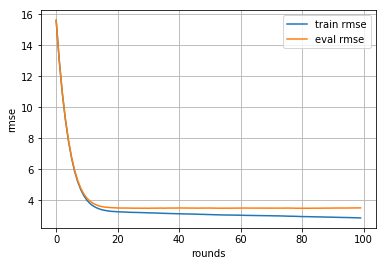

In [9]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

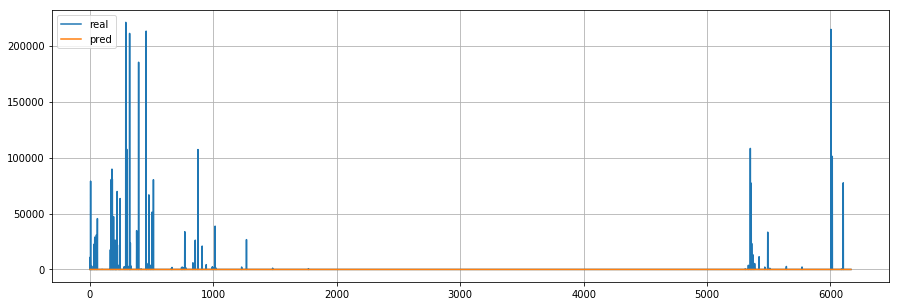

In [10]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['SalesKodateKen'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

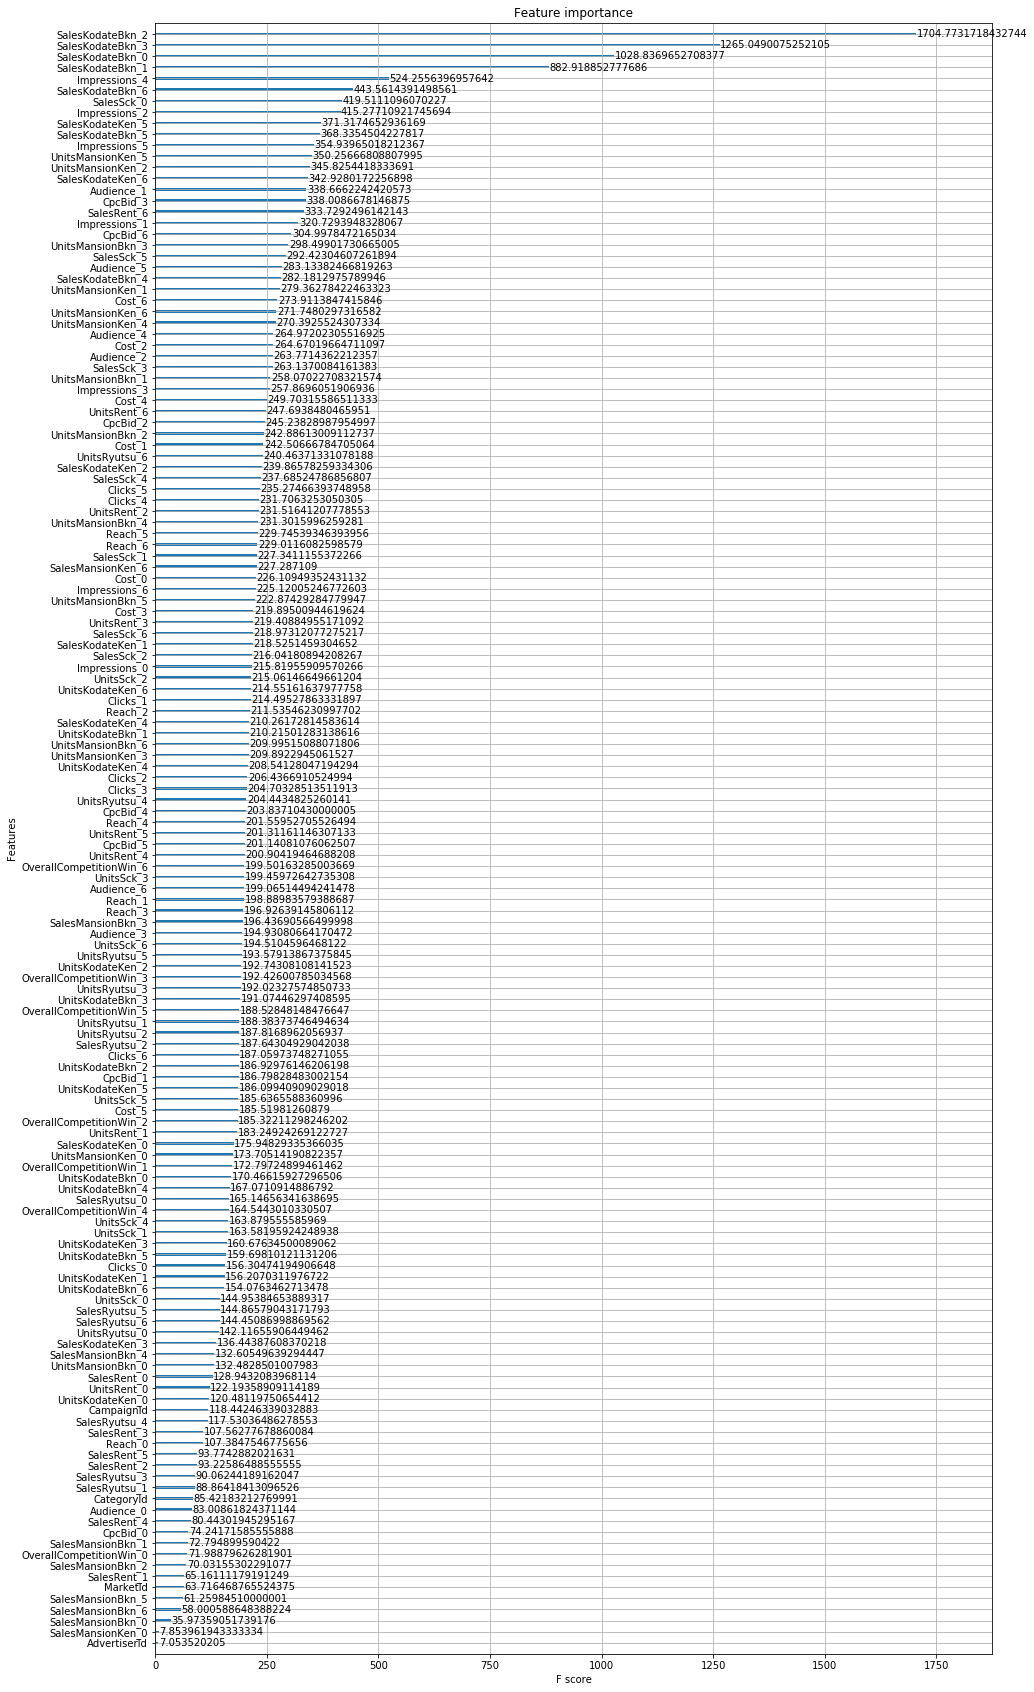

In [9]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [10]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['SalesKodateBkn_2',
 'SalesKodateBkn_3',
 'SalesKodateBkn_0',
 'SalesKodateBkn_1',
 'Impressions_4',
 'SalesKodateBkn_6',
 'SalesSck_0',
 'Impressions_2',
 'SalesKodateKen_5',
 'SalesKodateBkn_5',
 'Impressions_5',
 'UnitsMansionKen_5',
 'UnitsMansionKen_2',
 'SalesKodateKen_6',
 'Audience_1',
 'CpcBid_3',
 'SalesRent_6',
 'Impressions_1',
 'CpcBid_6',
 'UnitsMansionBkn_3',
 'SalesSck_5',
 'Audience_5',
 'SalesKodateBkn_4',
 'UnitsMansionKen_1',
 'Cost_6',
 'UnitsMansionKen_6',
 'UnitsMansionKen_4',
 'Audience_4',
 'Cost_2',
 'Audience_2',
 'SalesSck_3',
 'UnitsMansionBkn_1',
 'Impressions_3',
 'Cost_4',
 'UnitsRent_6',
 'CpcBid_2',
 'UnitsMansionBkn_2',
 'Cost_1',
 'UnitsRyutsu_6',
 'SalesKodateKen_2',
 'SalesSck_4',
 'Clicks_5',
 'Clicks_4',
 'UnitsRent_2',
 'UnitsMansionBkn_4',
 'Reach_5',
 'Reach_6',
 'SalesSck_1',
 'SalesMansionKen_6',
 'Cost_0',
 'Impressions_6',
 'UnitsMansionBkn_5',
 'Cost_3',
 'UnitsRent_3',
 'SalesSck_6',
 'SalesKodateKen_1',
 'SalesSck_2',
 'Impressions_0',